<a href="https://colab.research.google.com/github/lmontaldo/tryolabs_prueba/blob/main/Laura_Montaldo_TryolabsMLInterviewCars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Tryolabs' machine learning interview

If you are here, it's because your profile has already caught our attention. Congratulations!
This is a test so we can better learn about your skills by having you solve a real Machine Learning problem. The outcome is not the most important thing, we want to see your thought process and how you approach the problem, so make sure you write down everything you evaluate to do, approaches that didn't work, etc

# The project

The problem we want to analyze is [this Kaggle dataset](https://www.kaggle.com/datasets/thedevastator/uncovering-factors-that-affect-used-car-prices).

# What we expect

* An end to end solution, this means you need to be able to understand the description of the problem from the text, download the dataset, train and evaluate the model.
* We'll pay special attention to code quality and common pitfalls.
* You need to be able to explain each step and why it is there.
* Explain the data analysis you performed.

# The extra mile

* Carry on a dataset inconsistencies analysis.
* Explain what the models are taking into account to generate the predictions.
* In depth error analysis.

# The dataset

To make it accessible from your Colab notebook you need to mount your Drive:
```python
from google.colab import drive
drive.mount('/content/drive')
```
To check if you can access it from the notebook run:
```bash
%ls /content/drive/'My Drive'/Tryolabs-ML-Interview-Cars/data
```

To learn more about how Colab works check [this guide](https://colab.research.google.com/notebooks/welcome.ipynb).

# Introduction
The study initiates with an Exploratory Data Analysis (EDA), during which the data undergoes a thorough cleansing process, accompanied by a meticulous examination of any implausible price points. Progressing to the second phase, the approach pivots to feature engineering, distinguishing between numerical and categorical variables. This stage sets the foundation for training various predictive models within a structured pipeline. Each model's performance is  compared, culminating in a residual analysis to assess prediction accuracy.

In the subsequent phase, the focus shifts to the diverse array of brands and models available on eBay. Given the extensive variety, the study hones in on the three predominant brands in the used vehicle segment. For these selected brands, a comprehensive process is undertaken, encompassing the training and evaluation of models, comparison of their effectiveness, and an in-depth residual analysis. This targeted approach ensures a nuanced understanding of the market dynamics specific to these leading brands on the platform.

## Main preliminary insights:

* There are a total of 40 brands, 250 models, and description field with highly variable text and information repeated in other fields. Cleaning the model column is necessary to improve the analysis and make it more rigorous.

* The prices are skewed towards the left with entries at zero value. Absurd prices are removed from the study. A price recommendation system may improve user experience and contribute to reduce zombie sellers presence.

* The columns with missing values are categorical: notRepairedDamage, vehicleType, fuelType, model, gearbox.

* Relationship between prices and attributes:

   * Higher prices for lower kilometers: less than 30K kilometers present the higher median prices
   * Vehicle prices peak when the vehicles are around 10 years old
   * Positive correlation between Horse Power and median prices
   * Negative correlation between Age and Kms
   * The type of fuel, brand and car model are features with variable prices

* In relation to feature engineering, given the lack of a priori knowledge about whether the categorical variables possess an intrinsic ordering, one-hot encoding was chosen. As a disadvantage, the number of variables increases , leading to a loss in parsimony.

* There is no evidence of strong multicollinearity among variables.

* Reducing dimensionality through PCA does not appear to be a method to employ in this scheme.

* In relation to training, various models are compared. The most accurate would be a Random Forest with an RMSE of 0.182.
  
  * The age of the vehicule and the kilometers play a major role in how the model makes its predictions.

  * Errors behave normally using the random forest model.

* Considering the three main vehicle brands, CatBoost would be the most accurate model in all cases, resulting in errors with an approximately normal behavior



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)

In [3]:
! pip install deep_translator
from deep_translator import GoogleTranslator
translator = GoogleTranslator(source='auto', target='en')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import datetime

In [5]:
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
import sys
sys.path.append('/content/drive/My Drive/tryolabs')

In [7]:
autos_raw = pd.read_csv('/content/drive/My Drive/tryolabs/autos.csv')

# Exploratory Data Analysis (EDA)

## Data description

In this first stage, the goal is to gain a general understanding of the database that will be used for analysis. The objective is to know the number of rows and columns, the data type of each column, and the presence of missing data ($\textit{na}$bold text) to then proceed with the study of absurd prices since the target variable is car prices. Columns that do not provide useful information will be removed, and those that need to be processed will be handled so that the problem can be solved using statistical tools.


In [8]:
# number of rows by number of columns
print(f"Dataframe size: {autos_raw.shape}")

Dataframe size: (371528, 21)


In [9]:
print("Columns data types: \n")
autos_raw.info()

Columns data types: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand       

In [10]:
print("Is there any duplicated row:\n")
autos_raw.duplicated().sum()

Is there any duplicated row:



0

In [11]:
autos_raw.head(3)

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [12]:
print("Remove index column as it does not provide futher valuable information\n")
autos_raw = autos_raw.drop(autos_raw.columns[0], axis=1)

Remove index column as it does not provide futher valuable information



In [13]:
autos_raw.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [14]:
columns_to_lower = ['name', 'seller', 'offerType', 'vehicleType', 'gearbox', 'model','brand', 'notRepairedDamage','fuelType' ]
# Convert these columns to lowercase
for col in columns_to_lower:
    autos_raw[col] = autos_raw[col].str.lower()

In [15]:
autos_raw.describe(include=[float, int])

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


In [16]:
print(f"Number of rows with no price in it: {autos_raw[autos_raw['price']==0].shape[0]}")

Number of rows with no price in it: 10778


In [17]:
print("Missing values by columns and percentage of Nan in every column\n ")
nan_count = autos_raw.isna().sum()
# Sort columns by the count of NaN values in descending order
nan_count_sorted = nan_count.sort_values(ascending=False)
# Calculate the percentage of NaNs for each column (sorted)
nan_percentage_sorted = (nan_count_sorted / len(autos_raw)) * 100
# Combine into a new DataFrame
nan_summary = pd.DataFrame({
    'Total NaN Count': nan_count_sorted,
    'Percentage of NaNs': nan_percentage_sorted
})
# Display the new DataFrame
print(nan_summary)

Missing values by columns and percentage of Nan in every column
 
                     Total NaN Count  Percentage of NaNs
notRepairedDamage              72060           19.395577
vehicleType                    37869           10.192771
fuelType                       33386            8.986133
model                          20484            5.513447
gearbox                        20209            5.439429
kilometer                          0            0.000000
postalCode                         0            0.000000
nrOfPictures                       0            0.000000
dateCreated                        0            0.000000
brand                              0            0.000000
monthOfRegistration                0            0.000000
dateCrawled                        0            0.000000
name                               0            0.000000
powerPS                            0            0.000000
yearOfRegistration                 0            0.000000
abtest                

## Data cleaning

To gain initial insights and prevent the potential prediction errors that can arise from imputing NaN values, in this first stage, rows containing NaN values are removed. The primary rationale for this decision is linked to the fact that although the dataset includes a 'last seen' column that could serve as a time index, it is more practical to treat the dataset as a static snapshot of the current prices of used vehicles.

In [18]:
print("Remove Nan from data\n")
autos_raw = autos_raw.dropna()

Remove Nan from data



In [19]:
autos_raw.shape

(260956, 20)

In [20]:
autos_raw.lastSeen.nunique()

135866


### Translating columns from German to English


In [21]:
def translate_values(values):
    translator = GoogleTranslator(source='auto', target='en')
    return {value: translator.translate(value) for value in values}

In [22]:
columns_to_process = ['offerType', 'fuelType', 'seller','vehicleType','model' ]
for col in columns_to_process:
    # Replace NaN with 'Keine Daten'
    autos_raw[col].fillna('Keine Daten', inplace=True)
    # Get unique values
    unique_values = autos_raw[col].unique()
    # Translate the unique values
    translated_values = translate_values(unique_values)
    # Replace the original values with their translations
    autos_raw[col] = autos_raw[col].replace(translated_values)


### Removing columns that do not provide further information to the analysis



In [23]:
autos_raw.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
3,2016-03-17 16:54:04,golf_4_1_4__3türer,private,offer,1500,test,small car,2001,manuell,75,golf,150000,6,petrol,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,skoda_fabia_1.4_tdi_pd_classic,private,offer,3600,test,small car,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,bmw_316i___e36_limousine___bastlerfahrzeug__ex...,private,offer,650,test,limousine,1995,manuell,102,3er,150000,10,petrol,bmw,ja,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,peugeot_206_cc_110_platinum,private,offer,2200,test,cabrio,2004,manuell,109,2_row,150000,8,petrol,peugeot,nein,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,vw_derby_bj_80__scheunenfund,private,offer,0,test,limousine,1980,manuell,50,Others,40000,7,petrol,volkswagen,nein,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


In [24]:
print("Count of unique values from car name, model, brand and pictures: \n")
autos_raw.name.nunique(), autos_raw.model.nunique(), autos_raw.brand.nunique(), autos_raw.nrOfPictures.nunique()

Count of unique values from car name, model, brand and pictures: 



(146784, 250, 39, 1)

In [25]:
autos_raw.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [26]:
print(f"Month the car was registered:\n{np.sort(autos_raw['monthOfRegistration'].unique())}")


Month the car was registered:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [27]:
autos_raw=autos_raw[autos_raw['monthOfRegistration']>0]

In [28]:
to_drop=['dateCrawled', 'name', 'abtest', 'monthOfRegistration', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']
autos_raw.drop(to_drop, axis=1, inplace=True)

In [29]:
print(f"Year the car was registered:\n{np.sort(autos_raw['yearOfRegistration'].unique())}")

Year the car was registered:
[1910 1919 1923 1929 1930 1931 1932 1933 1934 1936 1937 1938 1939 1941
 1942 1943 1945 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957
 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971
 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


To establish limits on the registration year, the minimum year is taken as 1980 and the maximum year as 2023, since higher years are absurd data that may be the result of typing errors made by the user when  the data was added on the e-Bay platform.

In [30]:
autos=autos_raw[(autos_raw['yearOfRegistration']>=1980) & (autos_raw['yearOfRegistration']<=2023)]
print(f"Year the car was registered:\n{np.sort(autos['yearOfRegistration'].unique())}")

Year the car was registered:
[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


In [31]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251511 entries, 3 to 371527
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   seller              251511 non-null  object
 1   offerType           251511 non-null  object
 2   price               251511 non-null  int64 
 3   vehicleType         251511 non-null  object
 4   yearOfRegistration  251511 non-null  int64 
 5   gearbox             251511 non-null  object
 6   powerPS             251511 non-null  int64 
 7   model               251511 non-null  object
 8   kilometer           251511 non-null  int64 
 9   fuelType            251511 non-null  object
 10  brand               251511 non-null  object
 11  notRepairedDamage   251511 non-null  object
dtypes: int64(4), object(8)
memory usage: 24.9+ MB


In [32]:
autos.columns

Index(['seller', 'offerType', 'price', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand',
       'notRepairedDamage'],
      dtype='object')

In [33]:
autos['price'].describe()

count    2.515110e+05
mean     8.177118e+03
std      3.475290e+05
min      0.000000e+00
25%      1.600000e+03
50%      3.900000e+03
75%      8.799000e+03
max      1.000000e+08
Name: price, dtype: float64

### Ridiculous Prices Analysis

In [34]:
pd.options.display.float_format = '{:.2f}'.format

In [35]:
autos['price'].describe()

count     251511.00
mean        8177.12
std       347529.03
min            0.00
25%         1600.00
50%         3900.00
75%         8799.00
max     99999999.00
Name: price, dtype: float64

In [36]:
print(f"Percentage of rows with prices equal to zero over the total: {round(100*(autos[autos['price']==0].shape[0])/(autos.shape[0]),2)} %")

Percentage of rows with prices equal to zero over the total: 1.07 %


In [37]:
auto_sin_cero=autos[autos['price']!=0]

In [38]:
auto_sin_cero['price'].describe()

count     248813.00
mean        8265.79
std       349407.12
min            1.00
25%         1650.00
50%         3990.00
75%         8890.00
max     99999999.00
Name: price, dtype: float64

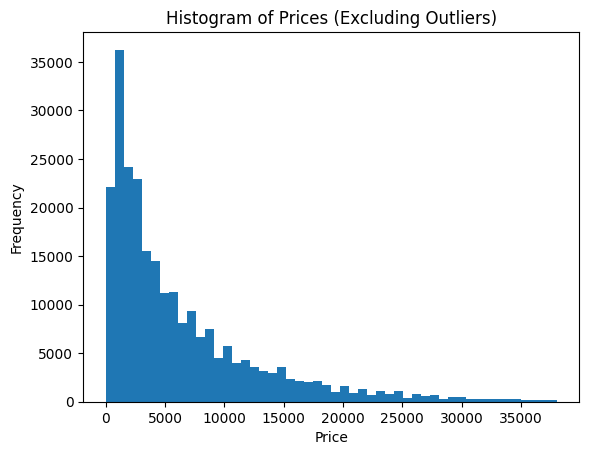

In [39]:
# Define a threshold to exclude extreme outliers
threshold = np.percentile(auto_sin_cero['price'], 99) #the 99th percentile is the value below which 99% of the data points in the auto_sin_cero['price'] column are found
pr=auto_sin_cero['price'][auto_sin_cero['price'] < threshold]
plt.hist(pr, bins=50)
plt.title('Histogram of Prices (Excluding Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [40]:
lower_bound = autos['price'].quantile(0.25)
upper_bound = autos['price'].quantile(0.75)
filtered_df = autos[(autos['price'] >= lower_bound) & (autos['price'] <= upper_bound)]

Skewness: 0.504201
Kurtosis: -0.908149


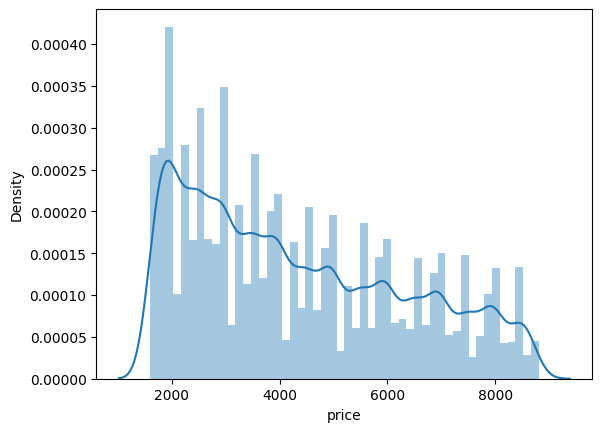

In [41]:
sns.distplot(filtered_df['price'])
#skewness and kurtosis
print("Skewness: %f" % filtered_df['price'].skew())
print("Kurtosis: %f" % filtered_df['price'].kurt())

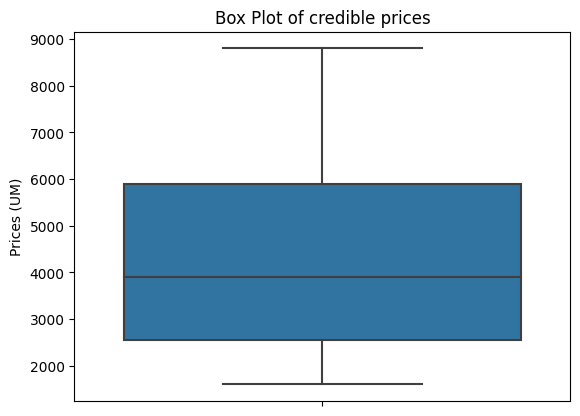

In [42]:
sns.boxplot(y=filtered_df['price'])
plt.title('Box Plot of credible prices')
plt.ylabel('Prices (UM)')
plt.show()

In [43]:
print(f"Percentage of data with credible prices in relation to the original amount of data: {round((filtered_df.shape[0]/autos.shape[0])*100,1)} %")

Percentage of data with credible prices in relation to the original amount of data: 50.1 %


In [44]:
print(f"Cantidad de filas con precios creíbles: {filtered_df.shape[0]}")

Cantidad de filas con precios creíbles: 125956


## Feature Engineering

### Feature Engineering: numerical variables

In [45]:
df=filtered_df.copy()

#### Feature PowerPS


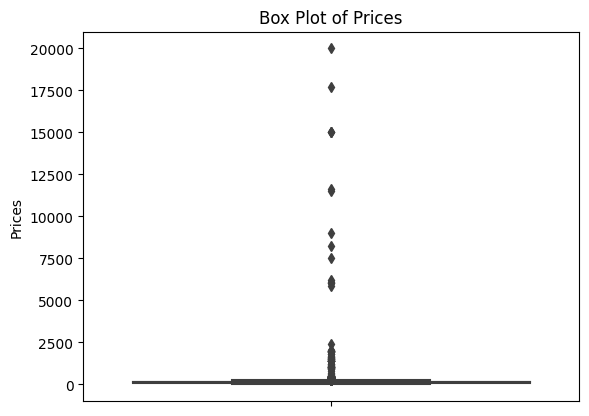

In [46]:
sns.boxplot(y=df['powerPS'])
plt.title('Box Plot of Prices')
plt.ylabel('Prices')
plt.show()

In [47]:
df.powerPS.describe()

count   125956.00
mean       119.86
std        138.10
min          0.00
25%         83.00
50%        115.00
75%        145.00
max      20000.00
Name: powerPS, dtype: float64

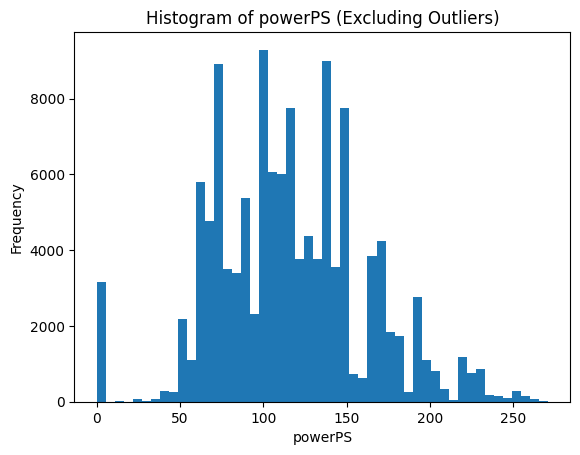

In [48]:
threshold = np.percentile(df['powerPS'], 99)
plt.hist(df['powerPS'][df['powerPS'] < threshold], bins=50)
plt.title('Histogram of powerPS (Excluding Outliers)')
plt.xlabel('powerPS')
plt.ylabel('Frequency')
plt.show()

It can be established that at a minimum, the vehicles would have between 50 and 60 HP. Therefore, the study trims the dataset for more than 50 HP.

In [49]:
df=df[(df.powerPS>50) & (df.powerPS<=200)]
print(f"Percentage of data with credible prices and HP in relation to the original amount of data.: {round((df.shape[0]/autos.shape[0])*100,1)} %")

Percentage of data with credible prices and HP in relation to the original amount of data.: 45.8 %


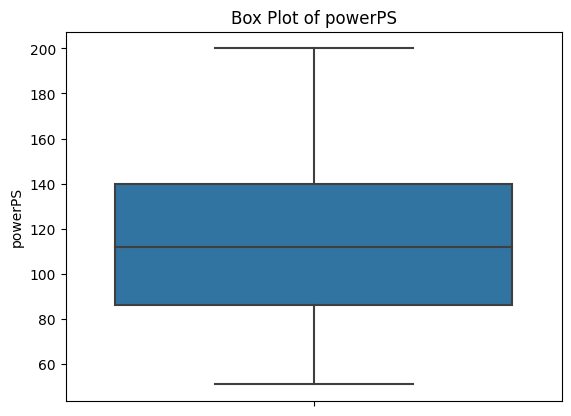

In [50]:
sns.boxplot(y=df['powerPS'])
plt.title('Box Plot of powerPS')
plt.ylabel('powerPS')
plt.show()

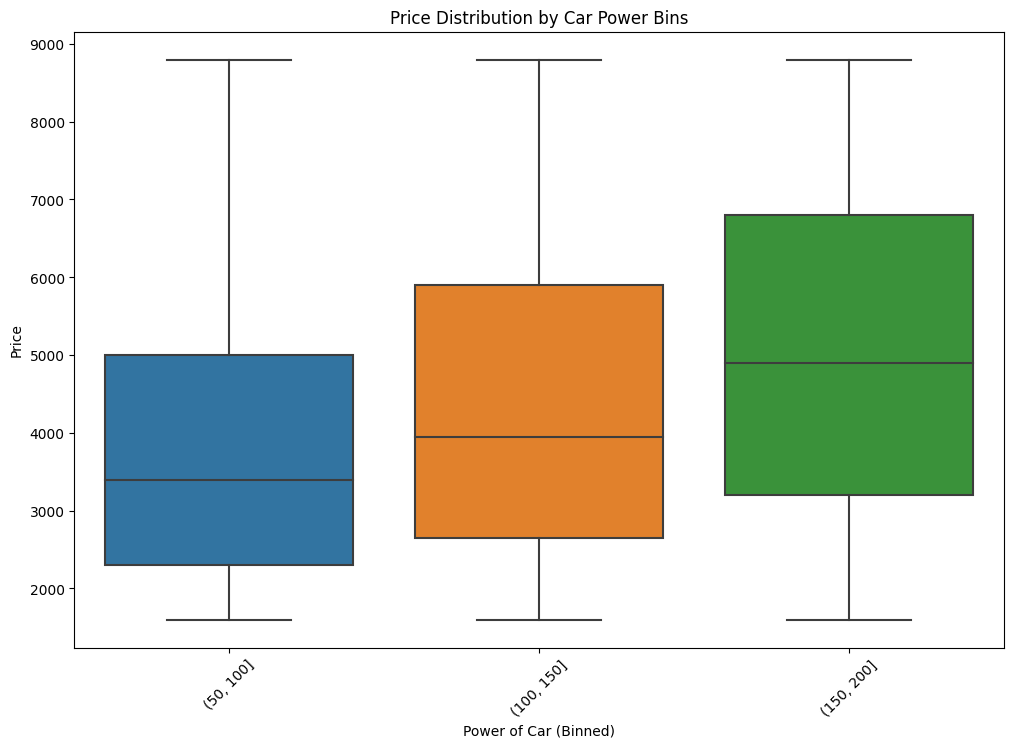

In [51]:
# Creating bins for 'PowerPS'
# Adjust the range and bin width as needed for your dataset
df['power_bin'] = pd.cut(df['powerPS'], bins=range(50, max(df['powerPS']) + 50, 50))
# Plotting using boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='power_bin', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Car Power Bins')
plt.xlabel('Power of Car (Binned)')
plt.ylabel('Price')
plt.show()

#### Feature Kilometers

In [52]:
df["kilometer"].describe()

count   115219.00
mean    129309.23
std      33999.87
min       5000.00
25%     125000.00
50%     150000.00
75%     150000.00
max     150000.00
Name: kilometer, dtype: float64

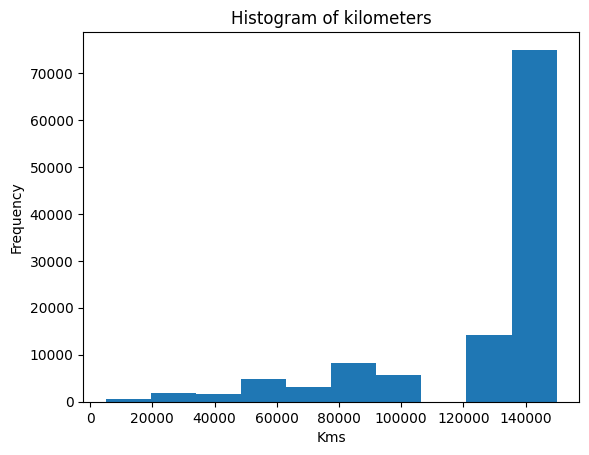

In [53]:
plt.hist(df["kilometer"])
plt.title('Histogram of kilometers')
plt.xlabel('Kms')
plt.ylabel('Frequency')
plt.show()

In [54]:
df.columns

Index(['seller', 'offerType', 'price', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand',
       'notRepairedDamage', 'power_bin'],
      dtype='object')

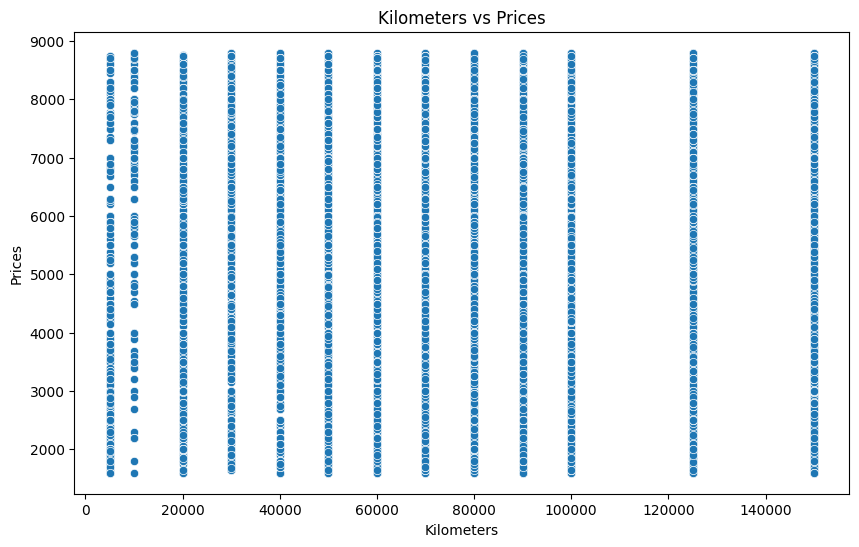

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kilometer', y='price', data=df)
plt.title('Kilometers vs Prices')
plt.xlabel('Kilometers')
plt.ylabel('Prices')
plt.show()

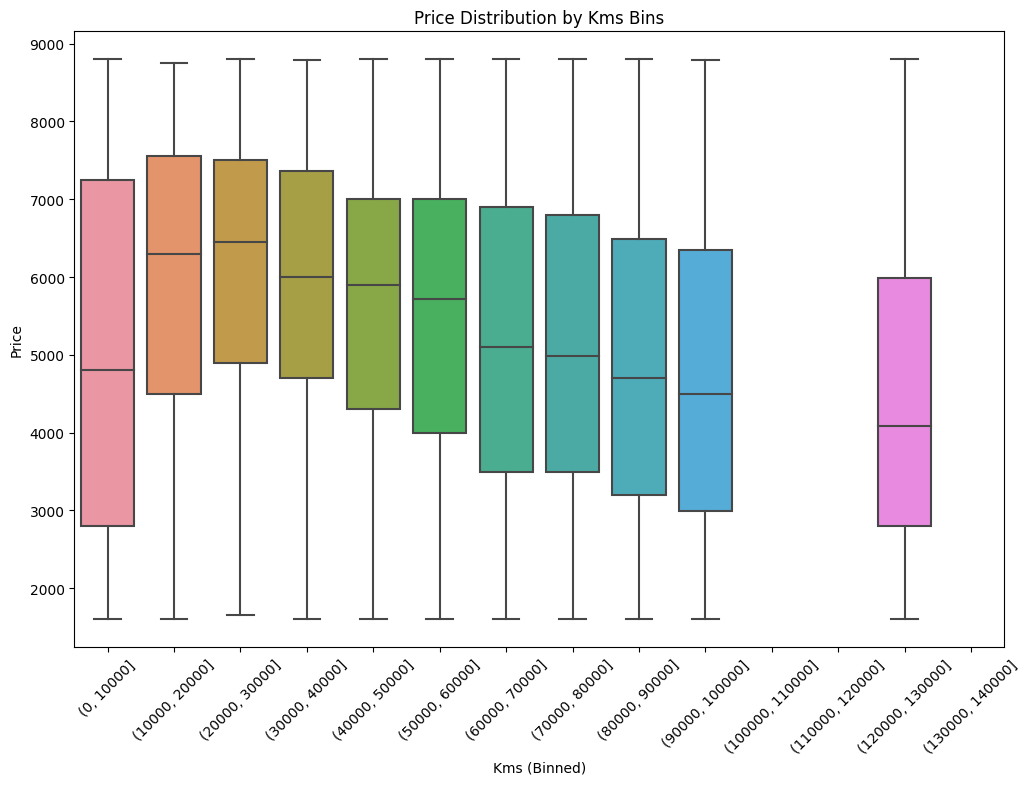

In [56]:
df['kms_bin'] = pd.cut(df['kilometer'], bins=range(0, 150000,10000))
# Plotting using boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='kms_bin', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Kms Bins')
plt.xlabel('Kms (Binned)')
plt.ylabel('Price')
plt.show()

#### Feature Vehicule age

In [57]:
current_year = datetime.datetime.now().year
df["antig"]=current_year -df["yearOfRegistration"]
df['price_float'] = df['price'].astype(float)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115219 entries, 4 to 371517
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   seller              115219 non-null  object  
 1   offerType           115219 non-null  object  
 2   price               115219 non-null  int64   
 3   vehicleType         115219 non-null  object  
 4   yearOfRegistration  115219 non-null  int64   
 5   gearbox             115219 non-null  object  
 6   powerPS             115219 non-null  int64   
 7   model               115219 non-null  object  
 8   kilometer           115219 non-null  int64   
 9   fuelType            115219 non-null  object  
 10  brand               115219 non-null  object  
 11  notRepairedDamage   115219 non-null  object  
 12  power_bin           115219 non-null  category
 13  kms_bin             40282 non-null   category
 14  antig               115219 non-null  int64   
 15  price_float      

In [59]:
df["antig"].describe()

count   115219.00
mean        19.26
std          4.69
min          5.00
25%         16.00
50%         19.00
75%         22.00
max         43.00
Name: antig, dtype: float64

#### Feature vehicules's age

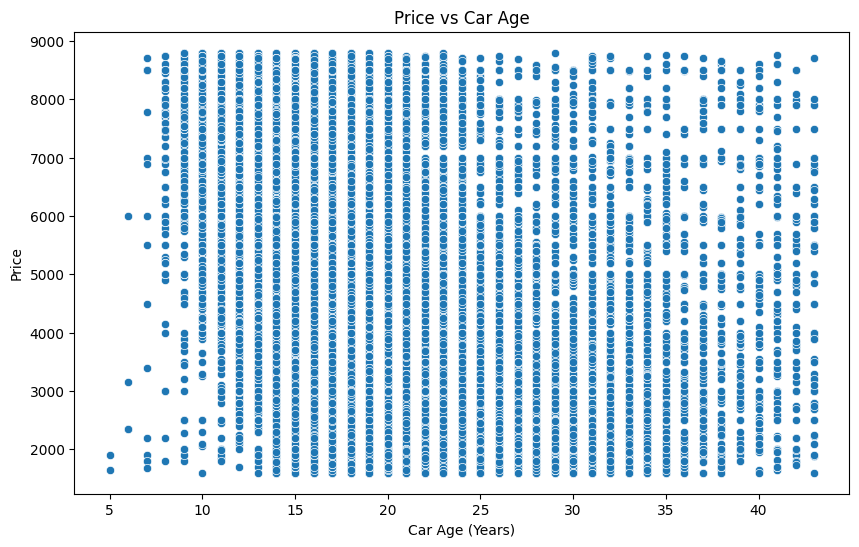

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='antig', y='price_float', data=df)
plt.title('Price vs Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Price')
plt.show()

Dispersión aleatoria: se añade una pequeña cantidad de ruido aleatorio a los puntos de datos, lo cual puede ayudar a separar puntos que se solapan. Esto no afectará la distribución general, pero puede hacer que los puntos de datos individuales sean más distinguibles.

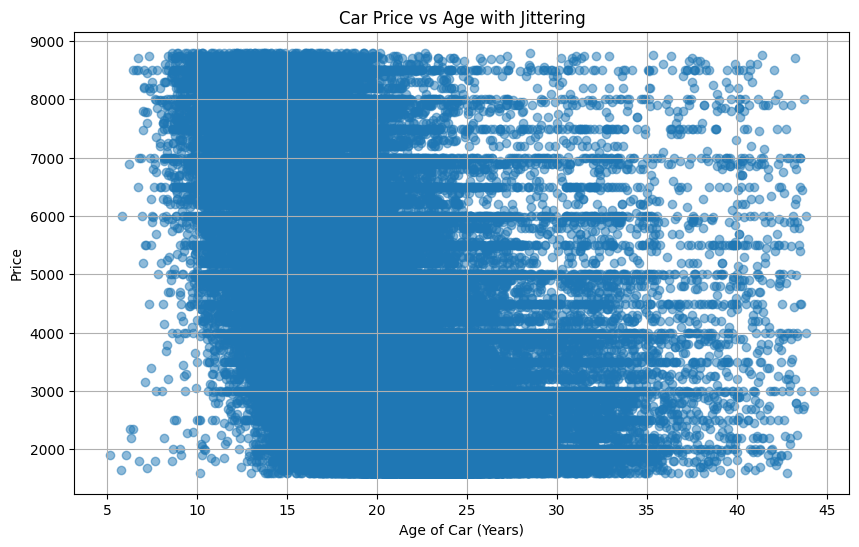

In [61]:
# Jittering: add a small random noise
jittered_age = df['antig'] + np.random.normal(0, 0.5, size=len(df))
# Create a scatter plot with jittering
plt.figure(figsize=(10, 6))
plt.scatter(jittered_age, df['price_float'], alpha=0.5)

plt.title('Car Price vs Age with Jittering')
plt.xlabel('Age of Car (Years)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

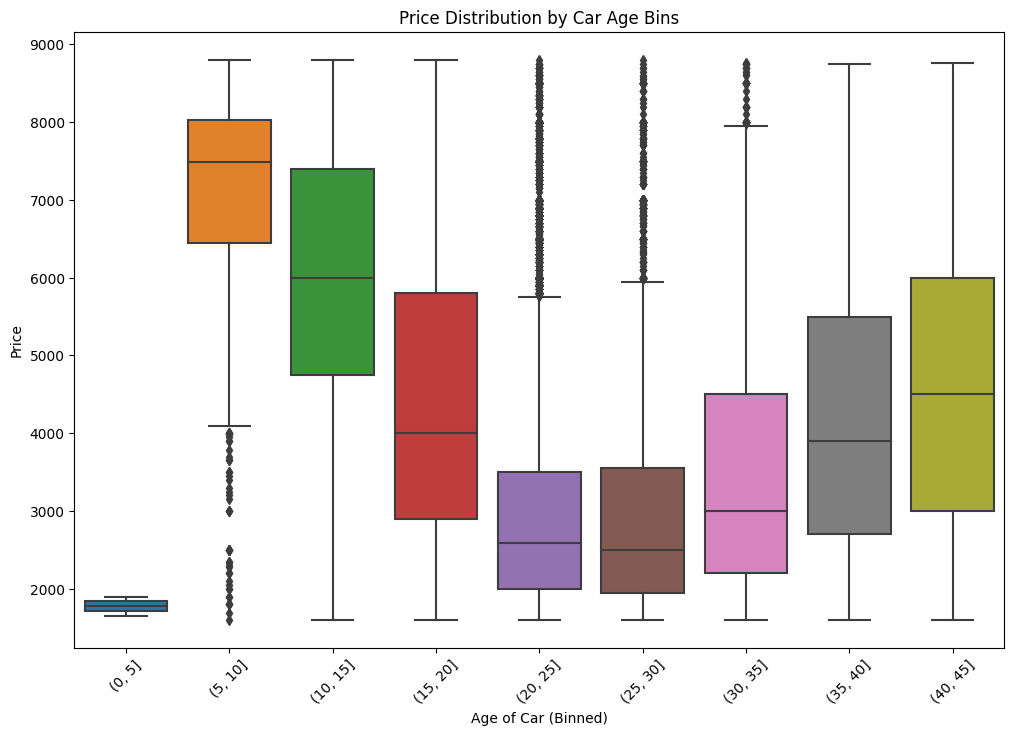

In [62]:
df['age_bin'] = pd.cut(df['antig'], bins=range(0, 50, 5))
# Plotting using boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_bin', y='price_float', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Car Age Bins')
plt.xlabel('Age of Car (Binned)')
plt.ylabel('Price')
plt.show()

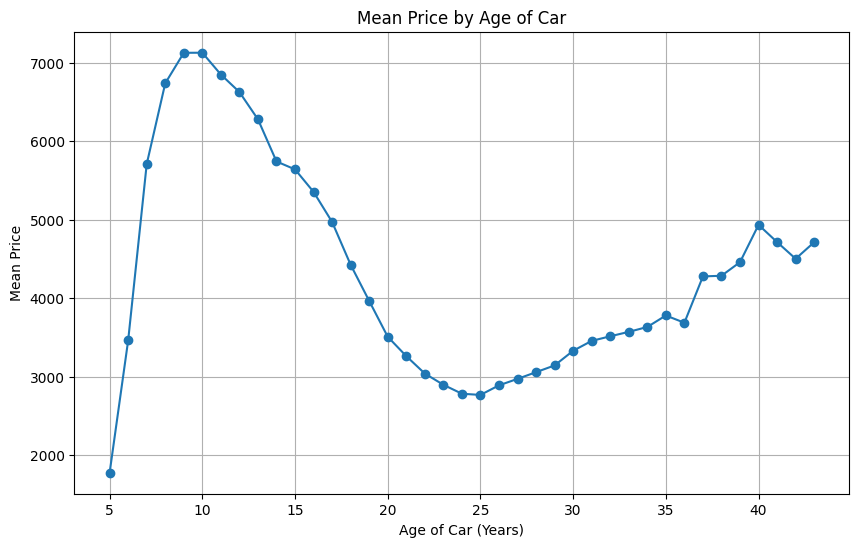

In [63]:
# Aggregate data
age_price_agg = df.groupby('antig')['price_float'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(age_price_agg['antig'], age_price_agg['price_float'], marker='o')

plt.title('Mean Price by Age of Car')
plt.xlabel('Age of Car (Years)')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

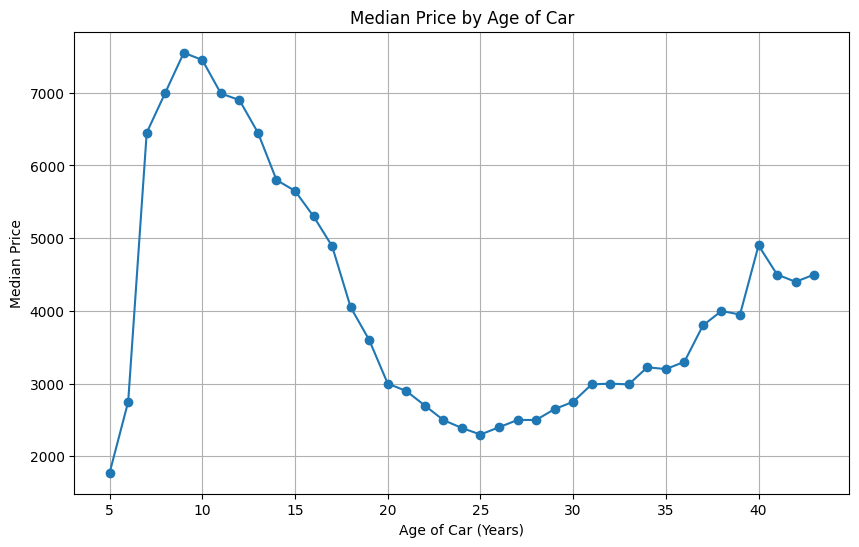

In [64]:
# Aggregate data
age_price_agg = df.groupby('antig')['price_float'].median().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(age_price_agg['antig'], age_price_agg['price_float'], marker='o')

plt.title('Median Price by Age of Car')
plt.xlabel('Age of Car (Years)')
plt.ylabel('Median Price')
plt.grid(True)
plt.show()

The median price is a statistical measure that represents the middle value in an ordered list of prices. To find the median price, first, all the prices are sorted in numerical order.

The median is a type of 'central tendency' measure, similar to the average, but in many cases, it is preferred over the average, especially when dealing with skewed distributions. This is because the median is less affected by outliers and extreme values. The price found in the middle of the list. Half of the cars are priced below this value, and the other half above it.

In [65]:
df.columns

Index(['seller', 'offerType', 'price', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand',
       'notRepairedDamage', 'power_bin', 'kms_bin', 'antig', 'price_float',
       'age_bin'],
      dtype='object')

In [66]:
cars=df.loc[:,['price','powerPS', 'kilometer', 'antig']]

In [67]:
print("Find most important features relative to target")
corr = cars.corr()
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

Find most important features relative to target
price        1.00
powerPS      0.21
kilometer   -0.28
antig       -0.48
Name: price, dtype: float64


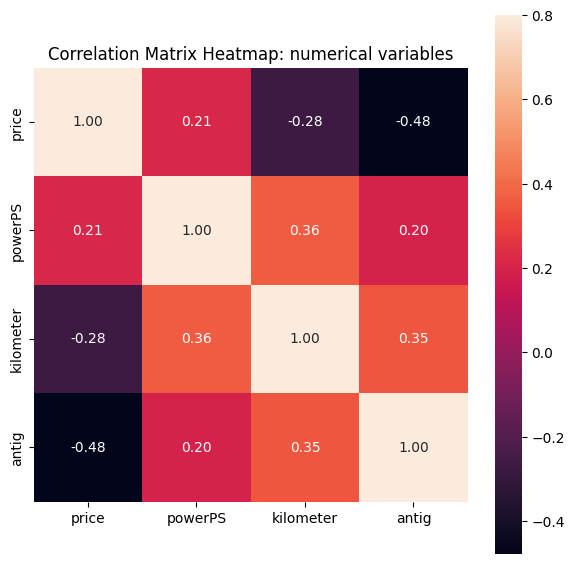

In [68]:
corrmat = cars.corr()
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True,  fmt='.2f', annot_kws={'size': 10})
ax.set_title('Correlation Matrix Heatmap: numerical variables')
plt.show()

### Feature Engineering: categorical variables

#### Not related to the vehicule: type of seller, type of offer, and sample size in the A/B test

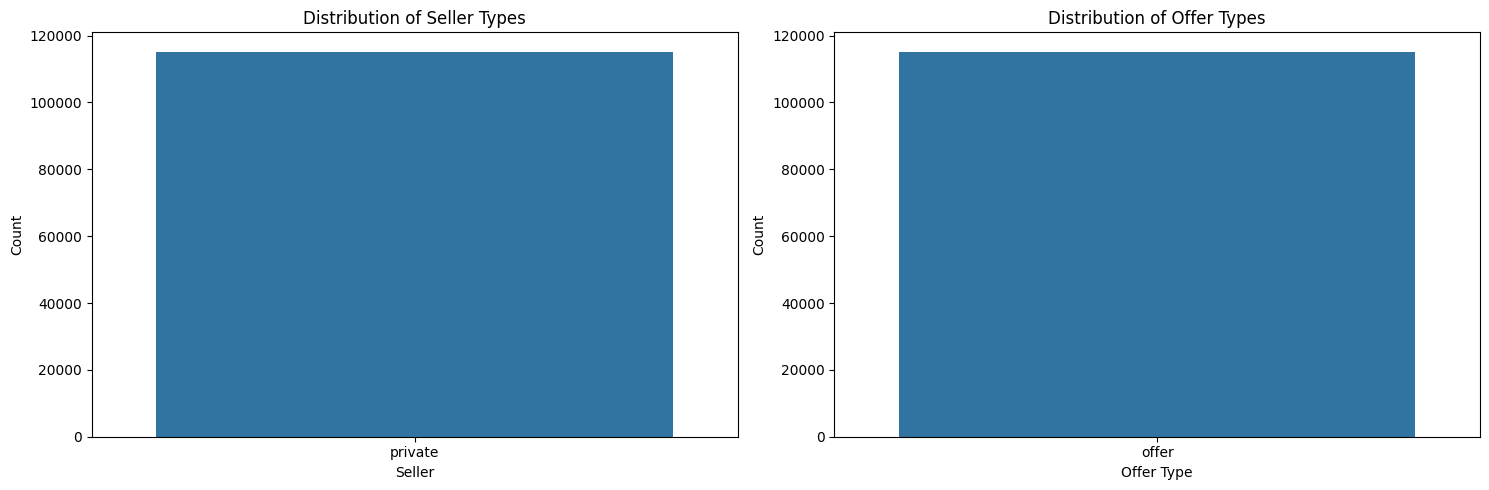

In [69]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot 'seller' distribution
sns.countplot(ax=axes[0], x='seller', data=df)
axes[0].set_title('Distribution of Seller Types')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Seller')

# Plot 'offerType' distribution
sns.countplot(ax=axes[1], x='offerType', data=df)
axes[1].set_title('Distribution of Offer Types')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Offer Type')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

These categorical variables would not necessarily contribute information to the analysis in the sense that these graphs make it evident that they would not be determinants of the prices, or they do not seem to be. To progress towards finding what would a priori appear to be a variable that determines the price of a used car, these three categorical variables are removed from the study.

In [70]:
keep=['price', 'vehicleType', 'gearbox', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage','antig']
df=df.loc[:,keep]

#### Exclusively linked to the characteristics of used vehicules

In [71]:
df.columns

Index(['price', 'vehicleType', 'gearbox', 'powerPS', 'model', 'kilometer',
       'fuelType', 'brand', 'notRepairedDamage', 'antig'],
      dtype='object')

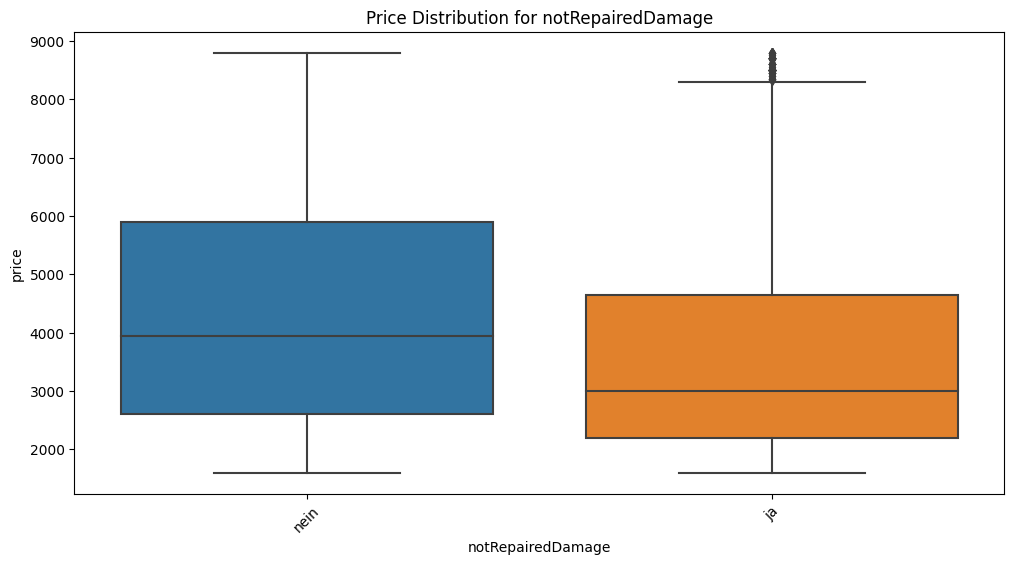

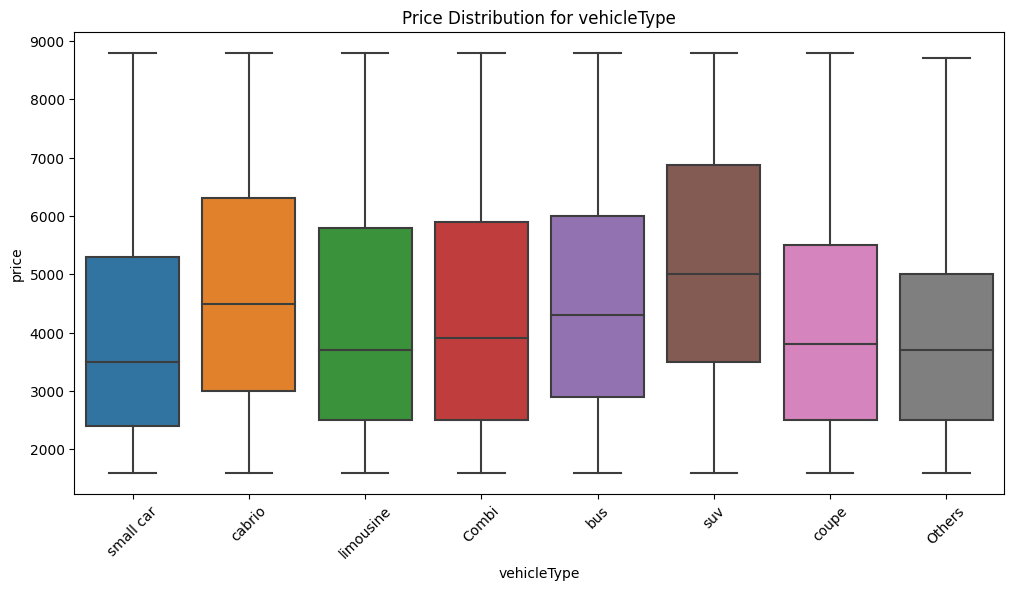

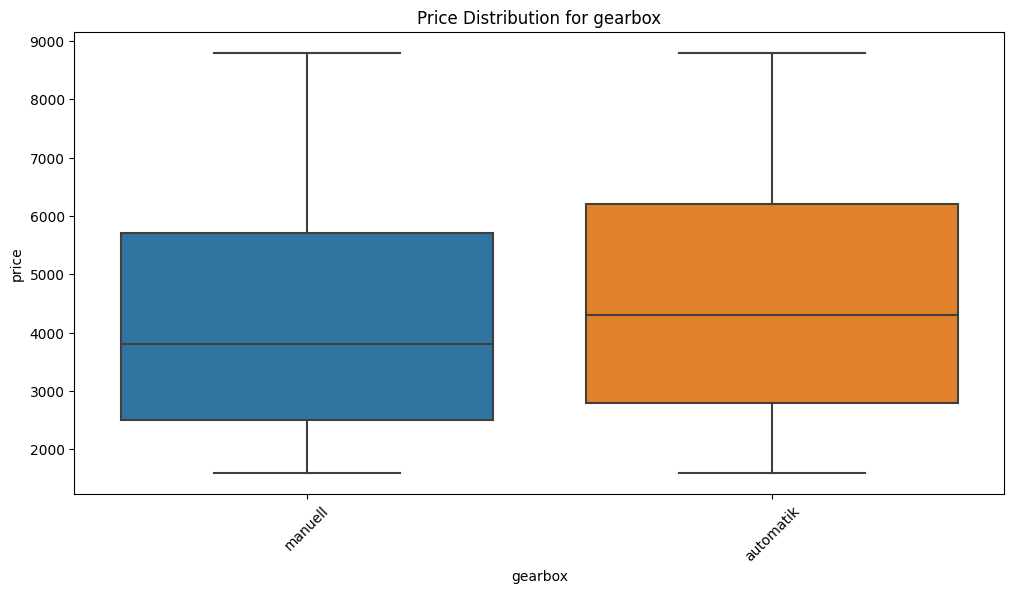

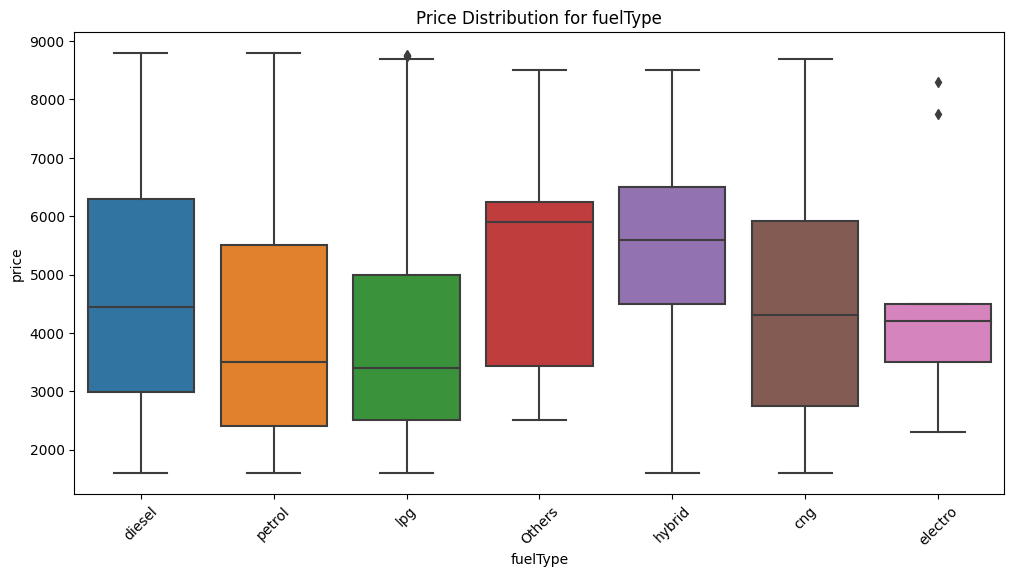

In [72]:
def plot_categorical(data, column, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y='price', data=data)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

categorical_columns = ['notRepairedDamage', 'vehicleType', 'gearbox',  'fuelType']
for column in categorical_columns:
    plot_title = f'Price Distribution for {column}'
    plot_categorical(df, column, plot_title)

In [73]:
df.columns

Index(['price', 'vehicleType', 'gearbox', 'powerPS', 'model', 'kilometer',
       'fuelType', 'brand', 'notRepairedDamage', 'antig'],
      dtype='object')

In [74]:
# Find the top 10 brands
top_10_brands = df['brand'].value_counts().nlargest(10).index

# Initialize a list to collect DataFrames
top_models_per_brand_dfs = []

for brand in top_10_brands:
    # Filter the DataFrame for the current brand
    brand_df = df[df['brand'] == brand]

    # Find the top 10 models for this brand
    top_models = brand_df['model'].value_counts().nlargest(10).index

    # Filter and add to the list
    top_models_df = brand_df[brand_df['model'].isin(top_models)]
    top_models_per_brand_dfs.append(top_models_df)

# Concatenate all the DataFrames in the list
top_models_per_brand_df = pd.concat(top_models_per_brand_dfs)

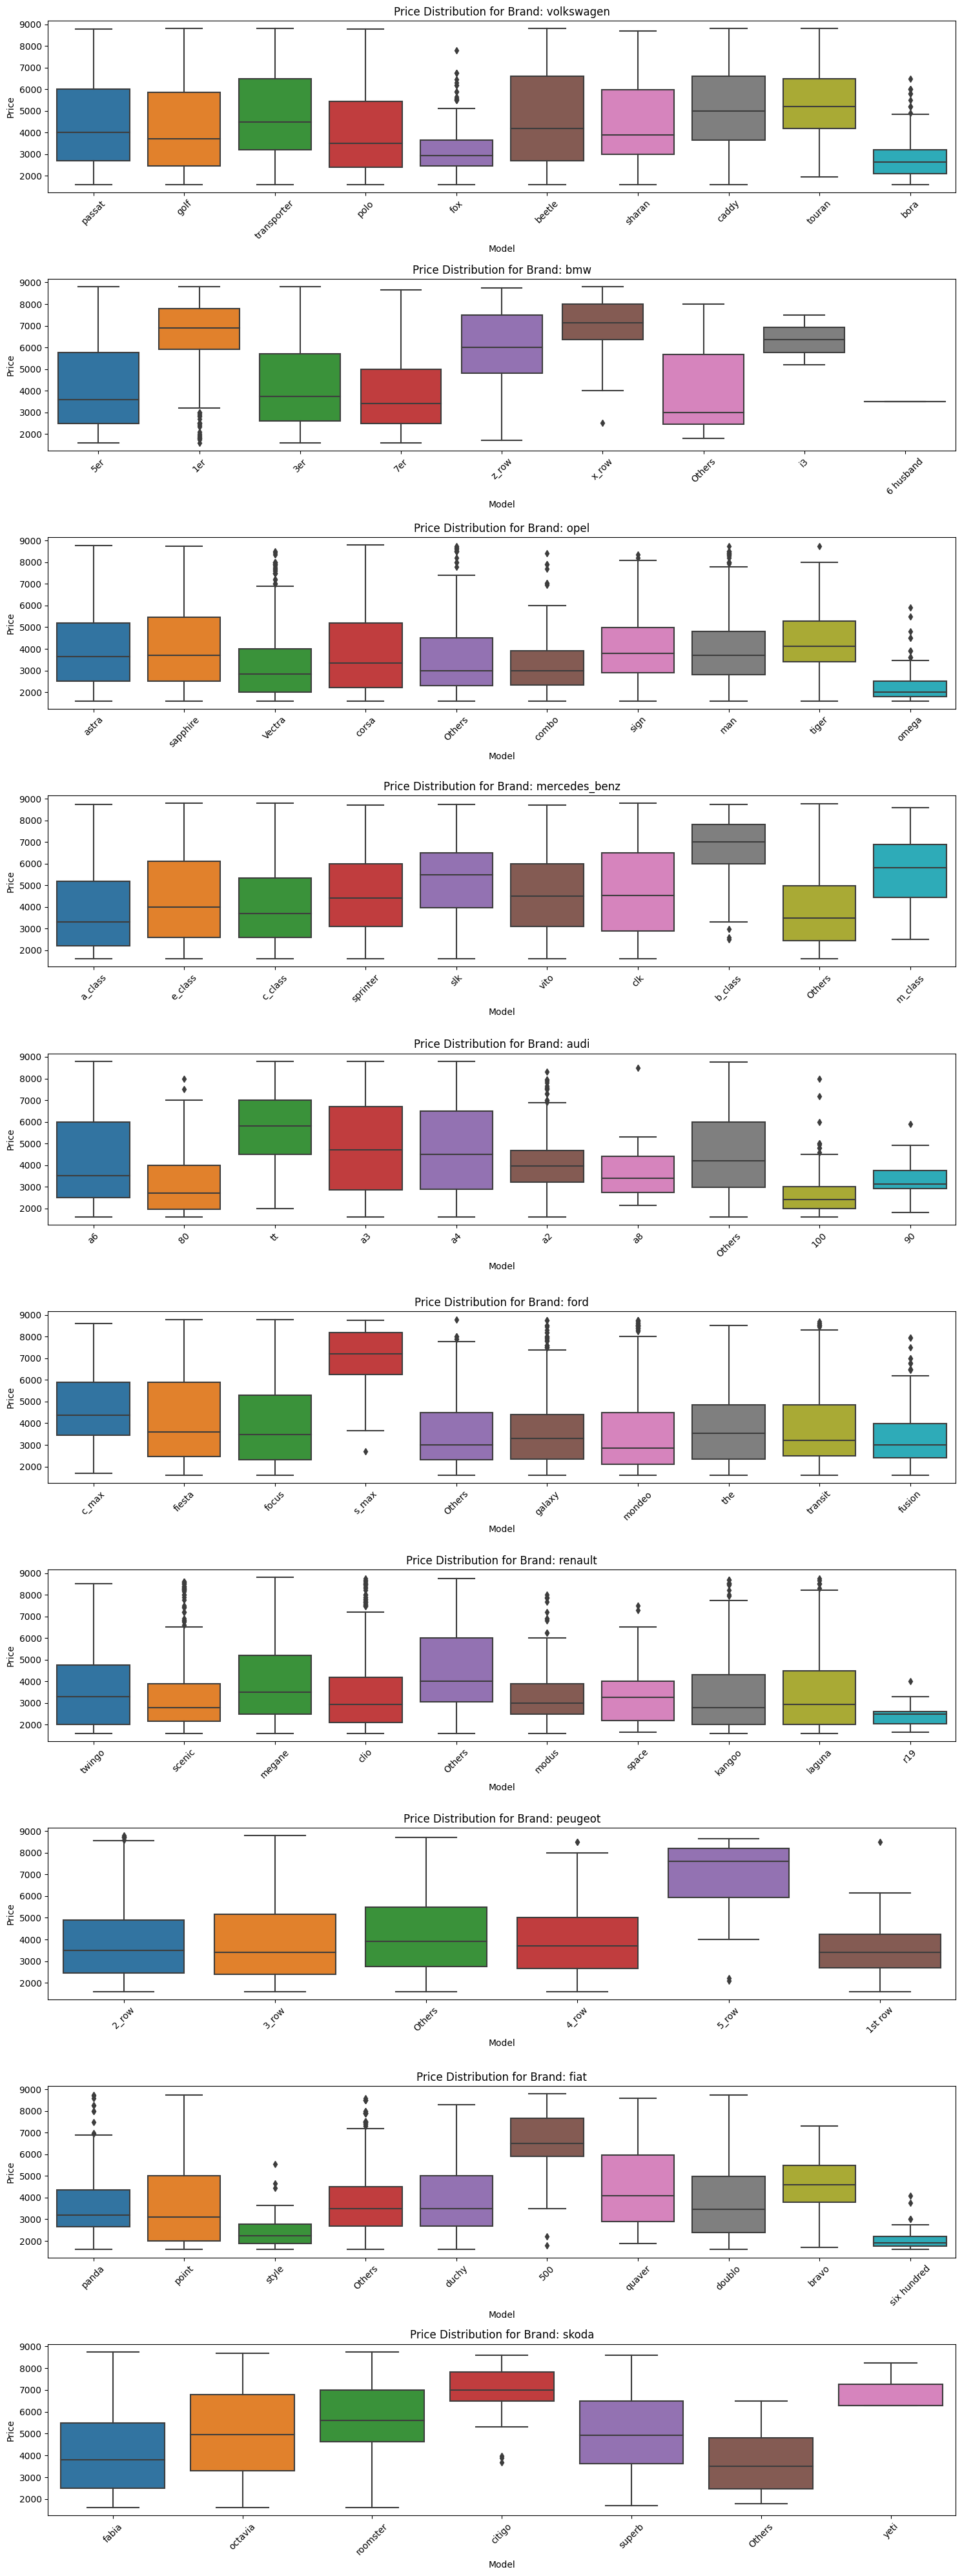

In [75]:
plt.figure(figsize=(15, 40))
unique_brands = top_models_per_brand_df['brand'].unique()

for i, brand in enumerate(unique_brands):
    # Create a subplot for each brand
    plt.subplot(len(unique_brands), 1, i + 1)

    # Filter the DataFrame for the current brand
    brand_df = top_models_per_brand_df[top_models_per_brand_df['brand'] == brand]

    # Create the box plot
    sns.boxplot(x='model', y='price', data=brand_df)
    plt.title(f'Price Distribution for Brand: {brand}')
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.ylabel('Price')
    plt.xlabel('Model')

# Adjust layout
plt.tight_layout()

Prices vary inside each category of brand, treating vehicules as homogenous items can lead to erronous predictions.

In [76]:
print("Removing Others for a simplier analysis")
data=top_models_per_brand_df
data.replace('Others', np.nan, inplace=True)
data.dropna(inplace=True)

Removing Others for a simplier analysis


### Feature Engineering: price normalization

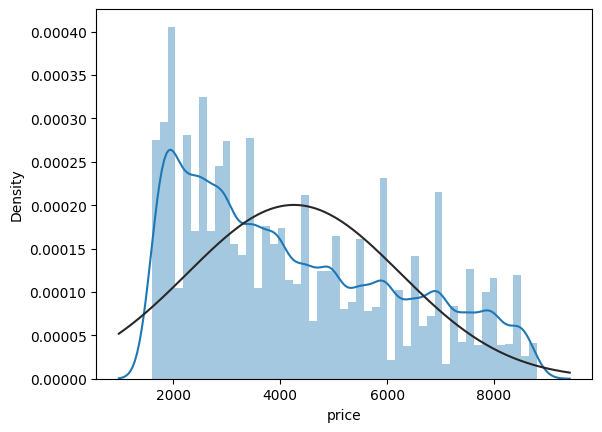

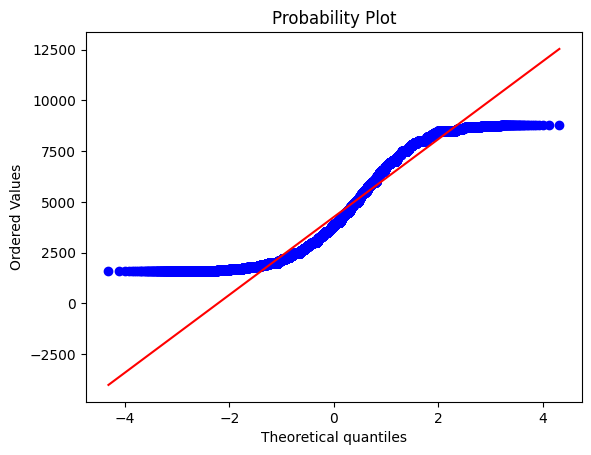

In [77]:
from scipy.stats import norm
from scipy import stats
sns.distplot(data['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['price'], plot=plt)

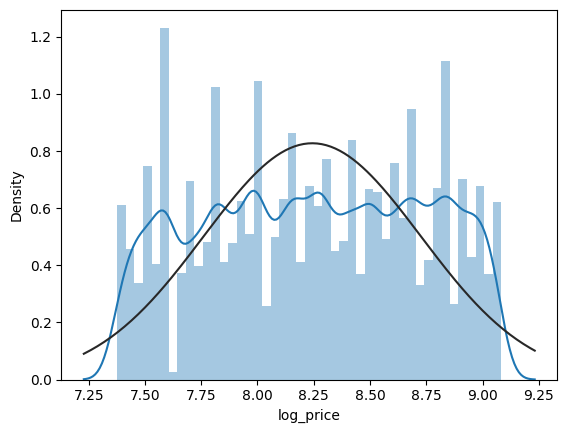

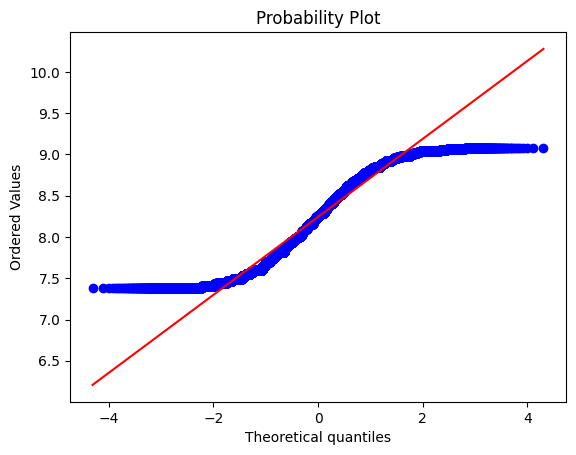

In [78]:
data['log_price'] = np.log(data['price'])
sns.distplot(data['log_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['log_price'], plot=plt)

Real-world data, especially something as complex as prices, often do not follow a perfect normal distribution. It's common to see skewed distributions, especially in economic data. A technique use to get improve data normalization  is Log Transformation. It may help to stabilize the variability but this is not the case when  considering all the vehicules in one dataframe.

## Data Preprocessing

### One-Hot encoding

One-hot encoding is a technique used to convert categorical variables into a form that could be provided to machine learning algorithms to do a better job in prediction. As a priori there is no order considering the categories if the vehicules one solution to avoid labeling the categorical data is one hor encoding. A challenge with this approach is the increasing number of variables that one can introduce to the problem.

In [79]:
data.notRepairedDamage.unique()

array(['ja', 'nein'], dtype=object)

In [80]:
mapping = {'manuell': 1, 'automatik': 0}
data['gearbox'] = data['gearbox'].map(mapping)

In [81]:
map = {'ja': 1, 'nein': 0}
data['notRepairedDamage'] = data['notRepairedDamage'].map(map)

In [82]:
dataset=pd.get_dummies(data, drop_first=True)

In [83]:
dataset.columns

Index(['price', 'gearbox', 'powerPS', 'kilometer', 'notRepairedDamage',
       'antig', 'log_price', 'vehicleType_bus', 'vehicleType_cabrio',
       'vehicleType_coupe',
       ...
       'fuelType_petrol', 'brand_bmw', 'brand_fiat', 'brand_ford',
       'brand_mercedes_benz', 'brand_opel', 'brand_peugeot', 'brand_renault',
       'brand_skoda', 'brand_volkswagen'],
      dtype='object', length=109)

### Feature Importance and correlation between variables

In [84]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85308 entries, 11 to 371308
Columns: 109 entries, price to brand_volkswagen
dtypes: float64(1), int64(6), uint8(102)
memory usage: 13.5 MB


In [85]:
X = dataset.drop(["price", "log_price"], axis=1)
y = dataset["log_price"]

The following code is intended to assess multicollinearity in the dataset. Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, which can make it difficult to determine the individual effect of each variable on the dependent variable.

Interpreting VIF Values

* VIF Value: A rule of thumb for interpreting VIF values is:

A value of 1 indicates no correlation between a given feature and any other feature.

Values between 1 and 5 suggest moderate correlation, but they are often not concerning.

Values greater than 5 or 10 indicate potentially problematic multicollinearity.

If a high VIF is found, the a good practice considers dropping the variable, combining it with another variable, or using techniques like Principal Component Analysis (PCA) to reduce multicollinearity.

VIF values:
      VIF Factor            Feature
0          7.64            gearbox
1         33.64            powerPS
2         28.22          kilometer
3          1.08  notRepairedDamage
4         35.33              antig
..          ...                ...
102         inf         brand_opel
103         inf      brand_peugeot
104         inf      brand_renault
105         inf        brand_skoda
106         inf   brand_volkswagen

[107 rows x 2 columns]


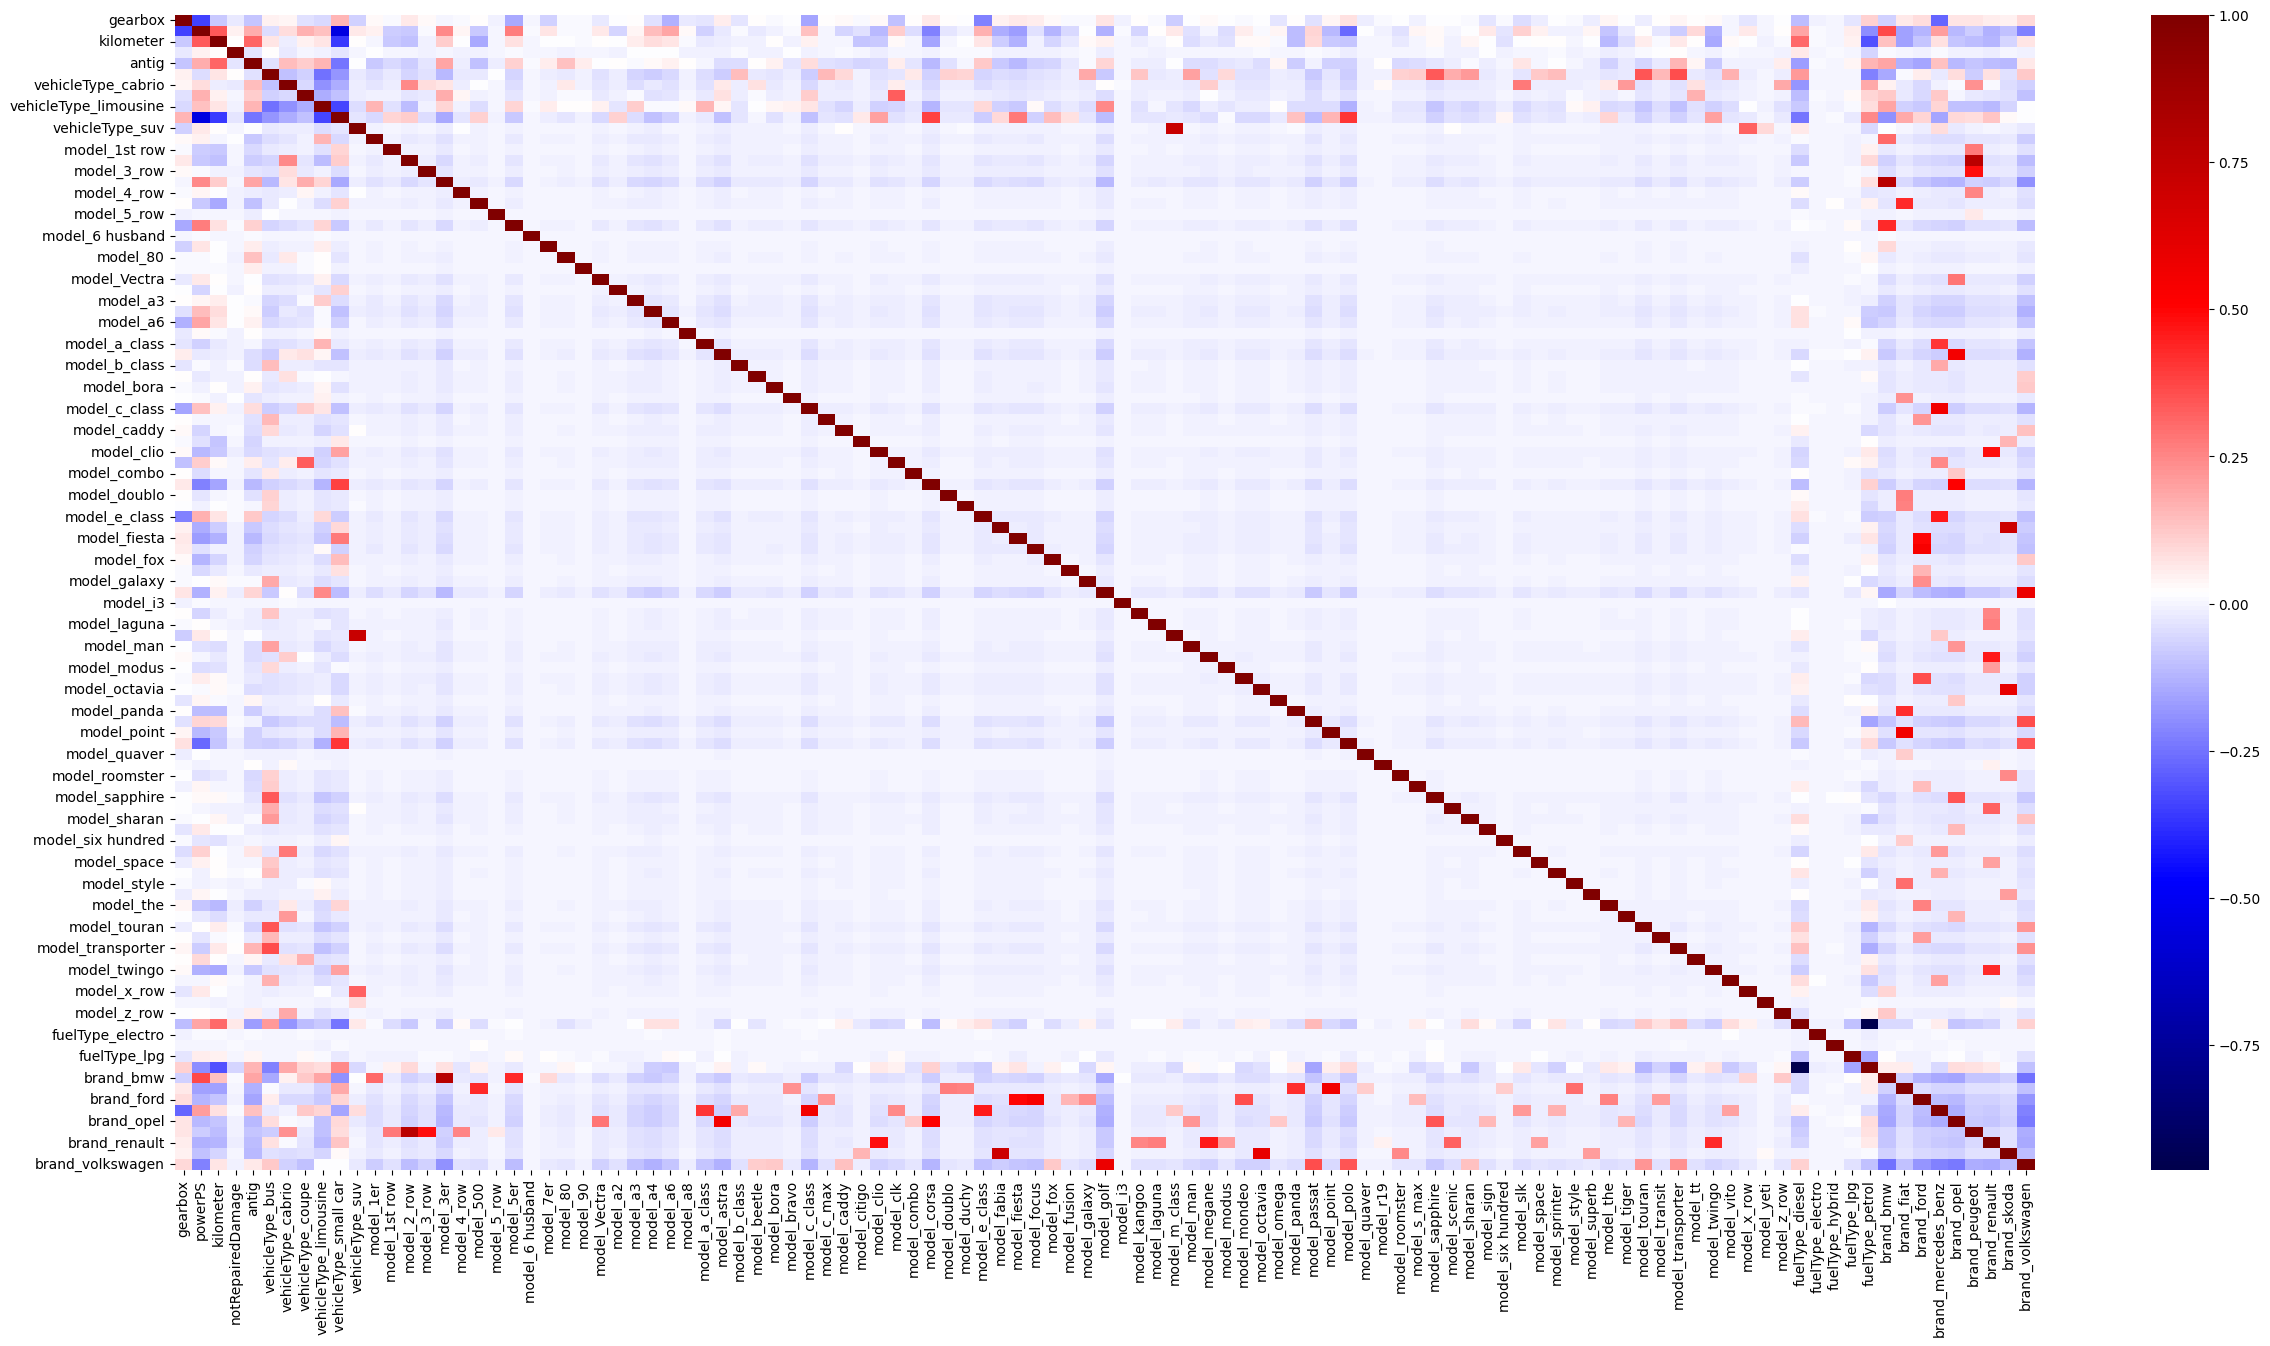

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# compute the correlation matrix of the features in my dataset, X
corr_matrix = X.corr()

# compute the VIF values
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns

# print the VIF values and visualize the correlation matrix
plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix, annot=False, cmap='seismic')
print("VIF values:\n", vif)

Reducing VIFs can help reduce multicollinearity, it's essential to ensure that the features you remove don't contain critical information necessary for your analysis or modeling. The balance between reducing multicollinearity and retaining meaningful features is crucial.

In [87]:
X.shape

(85308, 107)

In [88]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

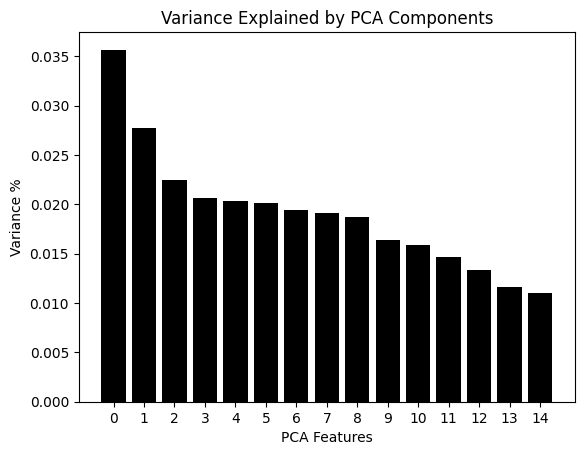

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume X_scaled is your standardized dataset
n_components = 15  # for example
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title("Variance Explained by PCA Components")
plt.show()


In [90]:
import pandas as pd

# Assuming pca is your PCA object after fitting to the data
explained_variance_ratio = pca.explained_variance_ratio_

# Creating a DataFrame
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': explained_variance_ratio.cumsum()
})
explained_variance_df.head()

,Principal Component,Explained Variance Ratio,Cumulative Explained Variance
0,PC1,0.04,0.04
1,PC2,0.03,0.06
2,PC3,0.02,0.09
3,PC4,0.02,0.11
4,PC5,0.02,0.13


The results from the Principal Component Analysis (PCA) suggest that each individual principal component (PC) explains a relatively small portion of the total variance in your dataset, and even cumulatively, the first 15 components only account for 29% of the variance. Each of the first 15 principal components explains between 1% to 4% of the variance. This indicates that the data's variability is spread out across many dimensions, and no single dimension captures a significant portion of the total variance.

The cumulative explained variance gradually increases with each additional principal component, but even after 15 components, it's at 29%. This suggests that the dataset is complex and high-dimensional, requiring a substantial number of components to capture most of the variance.

Given the spread of variance, it's essential to assess whether PCA is the best method for dimensionality reduction for this specific dataset.  PCA might not be ideal as the principal components are linear combinations of all original features and may not have a direct, interpretable meaning.

### Training and Test Set

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model training

This is a complex dataset, the best analysis direction would be to segment the vehicules by brand, and p

In [93]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, PassiveAggressiveRegressor, Ridge
from sklearn.ensemble import (HistGradientBoostingRegressor,
                              GradientBoostingRegressor, RandomForestRegressor,
                              BaggingRegressor)
from lightgbm import LGBMRegressor

# performance metric
from sklearn.metrics import mean_squared_error

# we need to scale the
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

In [94]:
# Build pipelines for all regressors, ensure features are scaled
hgbr_pipeline = Pipeline([('scaler', RobustScaler()),
                          ('hgbr', HistGradientBoostingRegressor())])

gbr_pipeline = Pipeline([('scaler', RobustScaler()),
                         ('gbr', GradientBoostingRegressor())])

lgbmr_pipeline = Pipeline([('scaler', RobustScaler()),
                           ('lgbmr', LGBMRegressor(reg_alpha=0.1))])

br_pipeline = Pipeline([('scaler', RobustScaler()),
                        ('br', BayesianRidge())])

par_pipeline = Pipeline([('scaler', RobustScaler()),
                         ('par', PassiveAggressiveRegressor())])

rfr_pipeline = Pipeline([('scaler', RobustScaler()),
                         ('rfr', RandomForestRegressor())])

brg_pipeline = Pipeline([('scaler', RobustScaler()),
                         ('brg', BaggingRegressor())])

en_pipeline = Pipeline([('scaler', RobustScaler()),
                        ('en', ElasticNet())])

xgbr_pipeline = Pipeline([('scaler', RobustScaler()),
                          ('xgbr', XGBRegressor(reg_alpha=0.1))])

In [95]:
# Create a list of the pipelines
pipelines = ['hgbr_pipeline', 'gbr_pipeline', 'lgbmr_pipeline', 'br_pipeline', 'par_pipeline', 'rfr_pipeline', 'brg_pipeline', 'en_pipeline', 'xgbr_pipeline']

In [96]:
# The first step is to create a list of results.
results = []

# Next, we will loop over the pipelines.
for pipeline_name in pipelines:

    # Get the pipeline object.
    pipeline = eval(pipeline_name)

    # Fit the pipeline to the training data.
    pipeline.fit(X_train, y_train)

    # Make predictions on the train data.
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the performance of the model.
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Store the results.
    results.append((pipeline_name, rmse))

# Next, we will sort the results based on MSE in ascending order.
results.sort(key=lambda x: x[1])

# Finally, we will print the results.
for pipeline_name, rmse in results:
    print("Root Mean Squared Error ({0}): {1}".format(pipeline_name, rmse))

# The model with the lowest RMSE is the best performer.
best_model_name = results[0][0]
print("Best model:", best_model_name)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 68246, number of used features: 99
[LightGBM] [Info] Start training from score 8.243059
Root Mean Squared Error (rfr_pipeline): 0.182415482288477
Root Mean Squared Error (brg_pipeline): 0.18599308334909692
Root Mean Squared Error (xgbr_pipeline): 0.229373527462353
Root Mean Squared Error (lgbmr_pipeline): 0.2412414473969296
Root Mean Squared Error (hgbr_pipeline): 0.2416998761611889
Root Mean Squared Error (gbr_pipeline): 0.2676620751345565
Root Mean Squared Error (br_pipeline): 0.30922098596856834
Root Mean Squared Error (par_pipeline): 0.4004737574544508
Root Mean Squared Error (en_pipeline): 0.48244198463435156
Best model: rfr_pipeline


In [97]:
y_train_pred_rfr_pipeline=rfr_pipeline.predict(X_train)
rfr_pipeline_rmse=np.sqrt(mean_squared_error(y_train, y_train_pred_rfr_pipeline))
print(f"Random Forest Regressor RMSE:{round(rfr_pipeline_rmse,3)}")

Random Forest Regressor RMSE:0.182


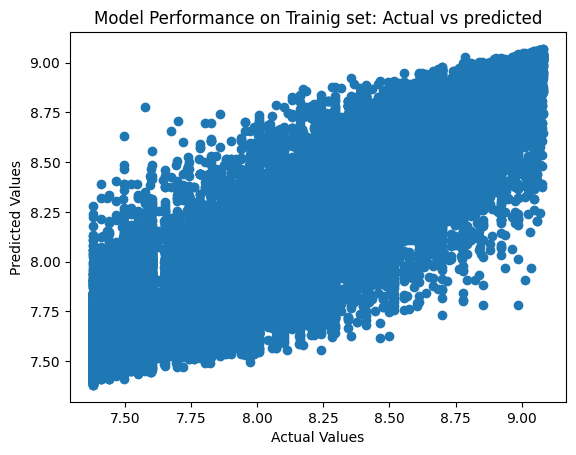

In [98]:
plt.scatter(y_train, y_train_pred_rfr_pipeline)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Model Performance on Trainig set: Actual vs predicted")
plt.show()

In [99]:
column_names = X.columns
X_train_df = pd.DataFrame(X_train, columns=column_names)

#### Feature Importance Analysis

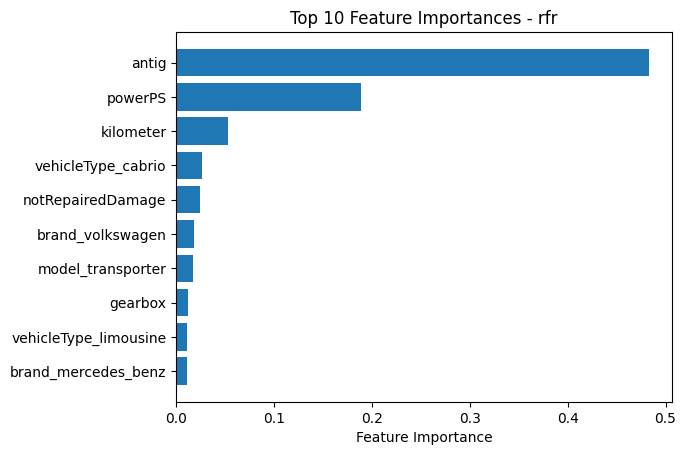

In [100]:
rfr_model = rfr_pipeline.named_steps['rfr']

# Plot the feature_importances
feature_importances =rfr_model.feature_importances_
feature_names = X_train_df.columns
sorted_indices = np.argsort(feature_importances)[-10:] # Select the top ten features

plt.figure()
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - rfr')
plt.show()

In [101]:
y_pred = rfr_pipeline.predict(X_test)

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")


MAE: 0.1834768295103669, MSE: 0.060878638334521167, RMSE: 0.24673596887061514, R2: 0.7378748451563018


## Error Analysis

Error analysis involves understanding where and why the model is making errors. This is a crucial step for improving model performance.

In [103]:
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred
})
print("Statistics of the error")
error_stats = error_df['Error'].describe()
print(error_stats)

Statistics of the error
count   17062.00
mean       -0.00
std         0.25
min        -1.33
25%        -0.14
50%         0.00
75%         0.14
max         1.13
Name: Error, dtype: float64


### Distribution of Errors

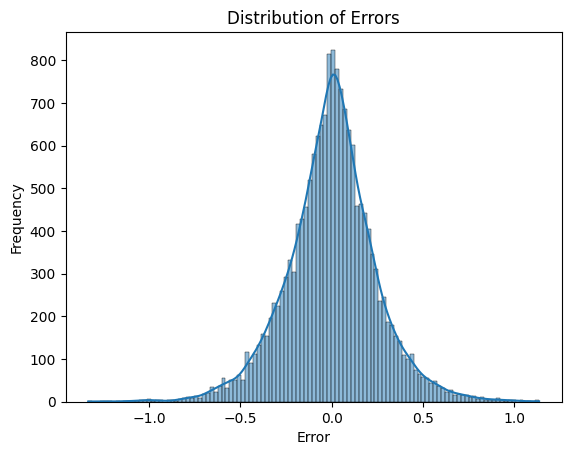

In [104]:
sns.histplot(error_df['Error'], kde=True)
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

### Plotting Errors Against Actual Values

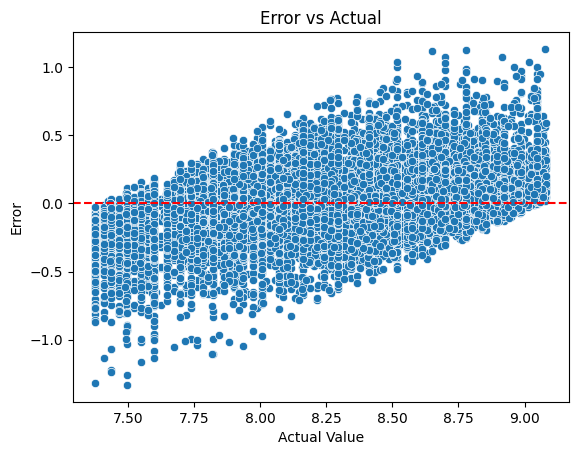

In [105]:
sns.scatterplot(x='Actual', y='Error', data=error_df)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Error vs Actual')
plt.xlabel('Actual Value')
plt.ylabel('Error')
plt.show()

## Analysis considering segmentation by brands: only 3 to simplify analysis

In [106]:
grouped_data = data.groupby('brand').agg(
    Count=('price', 'size'),
    Mean_Price=('price', 'mean')
).reset_index()

In [107]:
ordered_data = grouped_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
ordered_data.head()

,brand,Count,Mean_Price
0,volkswagen,23705,4343.71
1,bmw,11889,4550.32
2,opel,11133,3867.01
3,mercedes_benz,9592,4406.22
4,audi,8542,4584.93


In [108]:
filtered_df.head()

,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
4,private,offer,3600,small car,2008,manuell,69,fabia,90000,diesel,skoda,nein
6,private,offer,2200,cabrio,2004,manuell,109,2_row,150000,petrol,peugeot,nein
10,private,offer,2000,limousine,2004,manuell,105,3_row,150000,petrol,mazda,nein
11,private,offer,2799,Combi,2005,manuell,140,passat,150000,diesel,volkswagen,ja
17,private,offer,1750,small car,2004,automatik,75,twingo,150000,petrol,renault,nein


In [109]:
brands_to_filter = ['volkswagen', 'bmw', 'opel']
# Filter the DataFrame
filtered_df = data[data['brand'].isin(brands_to_filter)]
filtered_df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,antig,log_price
11,2799,Combi,1,140,passat,150000,diesel,volkswagen,1,18,7.94
75,6600,limousine,1,105,golf,150000,diesel,volkswagen,0,17,8.79
97,3850,limousine,1,131,passat,150000,diesel,volkswagen,0,20,8.26
122,4699,bus,1,110,transporter,150000,petrol,volkswagen,0,27,8.46
135,2750,Combi,1,131,passat,150000,diesel,volkswagen,0,22,7.92


In [110]:
! pip install scipy==1.10.1

In [111]:
!pip install pycaret==3.2.0

In [112]:
import pycaret
import scipy

In [113]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46727 entries, 11 to 371497
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              46727 non-null  int64  
 1   vehicleType        46727 non-null  object 
 2   gearbox            46727 non-null  int64  
 3   powerPS            46727 non-null  int64  
 4   model              46727 non-null  object 
 5   kilometer          46727 non-null  int64  
 6   fuelType           46727 non-null  object 
 7   brand              46727 non-null  object 
 8   notRepairedDamage  46727 non-null  int64  
 9   antig              46727 non-null  int64  
 10  log_price          46727 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 4.3+ MB


In [114]:
filtered_df.drop("price", inplace=True, axis=1)

In [115]:
from pycaret.regression import *

In [116]:
# Get the unique brands
unique_brands = filtered_df['brand'].unique()
df=filtered_df
# Loop through each brand
for brand in unique_brands:
    print(f"Running PyCaret Regression for Brand: {brand}")

    # Filter the DataFrame for the current brand
    brand_df = df[df['brand'] == brand]

    # Check if the brand-specific DataFrame is not too small
    if len(brand_df) > 30:  # Example threshold
        # Initialize PyCaret's setup for the current subset
        s = setup(data=brand_df, target='log_price',
                   preprocess=True, session_id=123)

        # Compare models or create a specific model
        best_model = compare_models()

        # Additional steps like model tuning or evaluation can be added here
        tuned_model = tune_model(best_model)
        evaluate_model(tuned_model)

        # You can also save the model or its results if needed
        # save_model(best_model, f'model_{brand}')
    else:
        print(f"Not enough data to run PyCaret for brand {brand}")


Running PyCaret Regression for Brand: volkswagen


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(23705, 10)"
4,Transformed data shape,"(23705, 30)"
5,Transformed train set shape,"(16593, 30)"
6,Transformed test set shape,"(7112, 30)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1820,0.0580,0.2407,0.7521,0.0262,0.0222,4.3230
lightgbm,Light Gradient Boosting Machine,0.1845,0.0591,0.2430,0.7473,0.0265,0.0225,1.2160
xgboost,Extreme Gradient Boosting,0.1833,0.0594,0.2436,0.7461,0.0265,0.0224,0.3660
rf,Random Forest Regressor,0.1869,0.0628,0.2505,0.7313,0.0273,0.0228,3.3730
gbr,Gradient Boosting Regressor,0.1931,0.0636,0.2521,0.7281,0.0274,0.0236,1.3910
et,Extra Trees Regressor,0.1891,0.0662,0.2572,0.7168,0.0280,0.0231,3.3900
knn,K Neighbors Regressor,0.2023,0.0729,0.2697,0.6885,0.0294,0.0247,0.3230
dt,Decision Tree Regressor,0.1980,0.0745,0.2728,0.6815,0.0297,0.0242,0.2220
ada,AdaBoost Regressor,0.2552,0.0952,0.3085,0.5929,0.0335,0.0311,1.0000
lr,Linear Regression,0.2462,0.1030,0.3208,0.5595,0.0351,0.0300,0.7710


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1816,0.0565,0.2377,0.7574,0.0259,0.0222
1,0.1809,0.0553,0.2352,0.7599,0.0256,0.0221
2,0.1821,0.0593,0.2436,0.7467,0.0266,0.0223
3,0.1818,0.0573,0.2394,0.7613,0.0261,0.0222
4,0.1846,0.0614,0.2477,0.7426,0.0270,0.0226
5,0.1881,0.0633,0.2516,0.7222,0.0274,0.0230
6,0.1827,0.0571,0.2389,0.7518,0.0260,0.0223
7,0.1725,0.0517,0.2275,0.7733,0.0247,0.0210
8,0.1854,0.0622,0.2494,0.7368,0.0272,0.0226


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Running PyCaret Regression for Brand: bmw


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(11889, 10)"
4,Transformed data shape,"(11889, 26)"
5,Transformed train set shape,"(8322, 26)"
6,Transformed test set shape,"(3567, 26)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2028,0.0699,0.2641,0.7034,0.0288,0.0247,2.3780
lightgbm,Light Gradient Boosting Machine,0.2048,0.0710,0.2662,0.6988,0.0290,0.0250,0.6150
xgboost,Extreme Gradient Boosting,0.2032,0.0717,0.2675,0.6956,0.0292,0.0248,0.3230
gbr,Gradient Boosting Regressor,0.2120,0.0738,0.2716,0.6865,0.0296,0.0259,0.5470
rf,Random Forest Regressor,0.2055,0.0743,0.2724,0.6845,0.0297,0.0251,1.4880
et,Extra Trees Regressor,0.2073,0.0771,0.2774,0.6730,0.0302,0.0253,1.3490
dt,Decision Tree Regressor,0.2145,0.0851,0.2914,0.6388,0.0318,0.0262,0.1650
knn,K Neighbors Regressor,0.2232,0.0870,0.2948,0.6307,0.0321,0.0273,0.3100
ada,AdaBoost Regressor,0.2656,0.1045,0.3232,0.5565,0.0351,0.0323,0.5050
br,Bayesian Ridge,0.2746,0.1249,0.3532,0.4701,0.0385,0.0334,0.1520


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2184,0.0814,0.2854,0.6561,0.0312,0.0267
1,0.2057,0.0707,0.2658,0.6884,0.0289,0.0250
2,0.2068,0.0720,0.2682,0.6996,0.0292,0.0252
3,0.2025,0.0723,0.2689,0.6835,0.0292,0.0247
4,0.2070,0.0707,0.2659,0.7131,0.0290,0.0253
5,0.2020,0.0681,0.2609,0.7326,0.0286,0.0248
6,0.1992,0.0671,0.2591,0.7020,0.0282,0.0242
7,0.1972,0.0657,0.2564,0.7252,0.0279,0.0240
8,0.1955,0.0621,0.2493,0.7210,0.0270,0.0236


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Running PyCaret Regression for Brand: opel


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(11133, 10)"
4,Transformed data shape,"(11133, 29)"
5,Transformed train set shape,"(7793, 29)"
6,Transformed test set shape,"(3340, 29)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1617,0.0456,0.2135,0.7880,0.0235,0.0200,2.6470
lightgbm,Light Gradient Boosting Machine,0.1631,0.0458,0.2139,0.7872,0.0235,0.0202,0.6970
xgboost,Extreme Gradient Boosting,0.1635,0.0470,0.2167,0.7815,0.0238,0.0202,0.3590
gbr,Gradient Boosting Regressor,0.1684,0.0481,0.2193,0.7763,0.0241,0.0208,0.7510
rf,Random Forest Regressor,0.1665,0.0496,0.2226,0.7695,0.0245,0.0206,1.7830
et,Extra Trees Regressor,0.1708,0.0538,0.2318,0.7499,0.0255,0.0211,1.7990
knn,K Neighbors Regressor,0.1833,0.0596,0.2440,0.7232,0.0268,0.0226,0.2540
br,Bayesian Ridge,0.1863,0.0612,0.2472,0.7159,0.0274,0.0231,0.1530
ridge,Ridge Regression,0.1863,0.0613,0.2474,0.7154,0.0274,0.0231,0.1440
lr,Linear Regression,0.1864,0.0614,0.2476,0.7150,0.0274,0.0231,0.1530


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1596,0.0454,0.2130,0.7816,0.0233,0.0196
1,0.1587,0.0449,0.2118,0.7919,0.0233,0.0196
2,0.1576,0.0417,0.2042,0.8021,0.0225,0.0195
3,0.1693,0.0483,0.2197,0.7717,0.0241,0.0208
4,0.1685,0.0493,0.2221,0.7679,0.0244,0.0208
5,0.1645,0.0473,0.2175,0.7724,0.0240,0.0204
6,0.1578,0.0419,0.2046,0.8067,0.0226,0.0195
7,0.1625,0.0474,0.2178,0.7926,0.0240,0.0201
8,0.1616,0.0449,0.2119,0.7960,0.0233,0.0200


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Evaluating for Brand: volkswagen


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(23705, 10)"
4,Transformed data shape,"(23705, 30)"
5,Transformed train set shape,"(16593, 30)"
6,Transformed test set shape,"(7112, 30)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1812,0.0561,0.2369,0.7580,0.0258,0.0221
1,0.1814,0.0578,0.2405,0.7565,0.0262,0.0222
2,0.1842,0.0612,0.2474,0.7376,0.0270,0.0225
3,0.1786,0.0550,0.2345,0.7600,0.0255,0.0218
4,0.1857,0.0604,0.2457,0.7467,0.0268,0.0227
Mean,0.1822,0.0581,0.2410,0.7517,0.0262,0.0223
Std,0.0025,0.0024,0.0049,0.0084,0.0006,0.0003


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1809,0.0559,0.2363,0.7590,0.0257,0.0221
1,0.1823,0.0585,0.2418,0.7537,0.0264,0.0223
2,0.1852,0.0618,0.2486,0.7349,0.0271,0.0227
3,0.1791,0.0551,0.2348,0.7593,0.0255,0.0219
4,0.1873,0.0610,0.2471,0.7438,0.0269,0.0229
Mean,0.1829,0.0585,0.2417,0.7502,0.0263,0.0223
Std,0.0030,0.0027,0.0055,0.0095,0.0006,0.0004


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.1826,0.0585,0.2419,0.7471,0.0264,0.0223


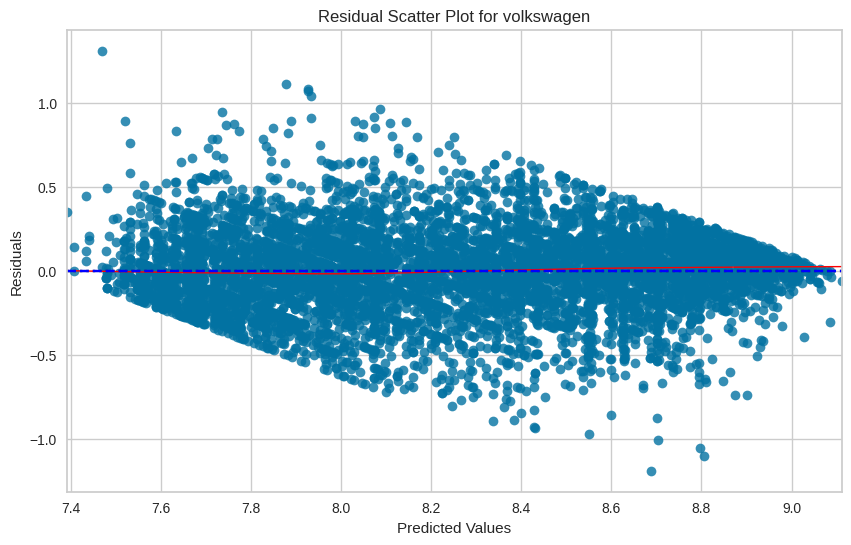

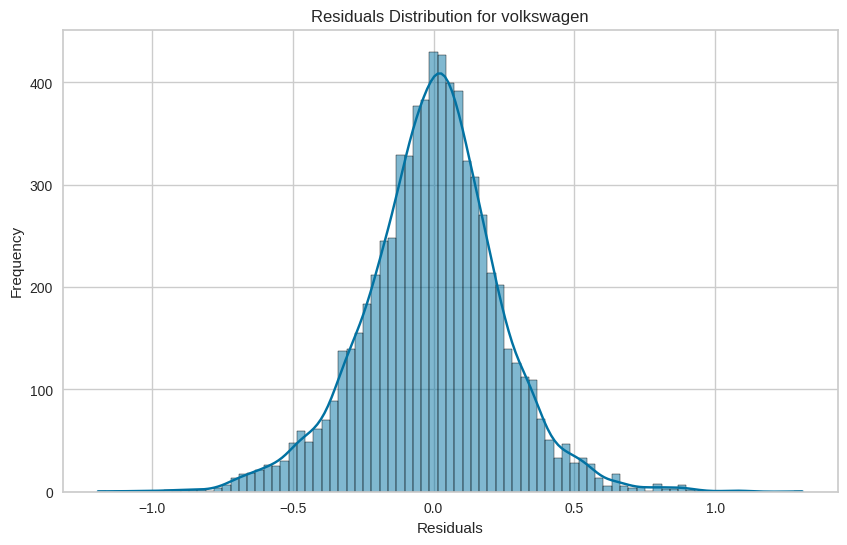

Evaluating for Brand: bmw


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(11889, 10)"
4,Transformed data shape,"(11889, 26)"
5,Transformed train set shape,"(8322, 26)"
6,Transformed test set shape,"(3567, 26)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2115,0.0760,0.2757,0.6724,0.0301,0.0258
1,0.2042,0.0723,0.2689,0.6909,0.0293,0.0249
2,0.2052,0.0700,0.2647,0.7205,0.0289,0.0251
3,0.1973,0.0665,0.2579,0.7138,0.0281,0.0240
4,0.1999,0.0676,0.2600,0.7065,0.0283,0.0243
Mean,0.2036,0.0705,0.2654,0.7008,0.0289,0.0248
Std,0.0049,0.0034,0.0064,0.0173,0.0007,0.0006


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2130,0.0768,0.2772,0.6687,0.0302,0.0260
1,0.2050,0.0723,0.2688,0.6910,0.0292,0.0250
2,0.2051,0.0698,0.2643,0.7213,0.0289,0.0251
3,0.1983,0.0672,0.2592,0.7109,0.0282,0.0241
4,0.1999,0.0673,0.2594,0.7079,0.0282,0.0243
Mean,0.2043,0.0707,0.2658,0.7000,0.0290,0.0249
Std,0.0051,0.0036,0.0067,0.0184,0.0007,0.0007


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.1989,0.0679,0.2606,0.7094,0.0285,0.0243


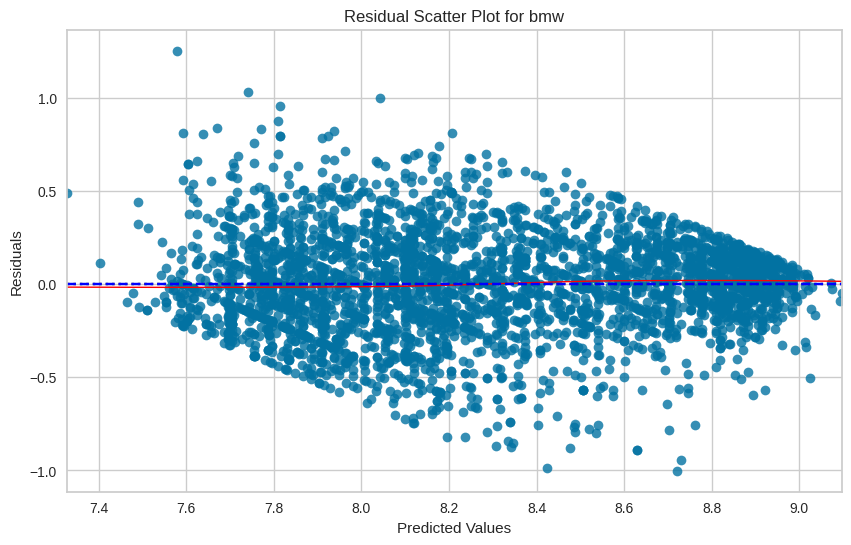

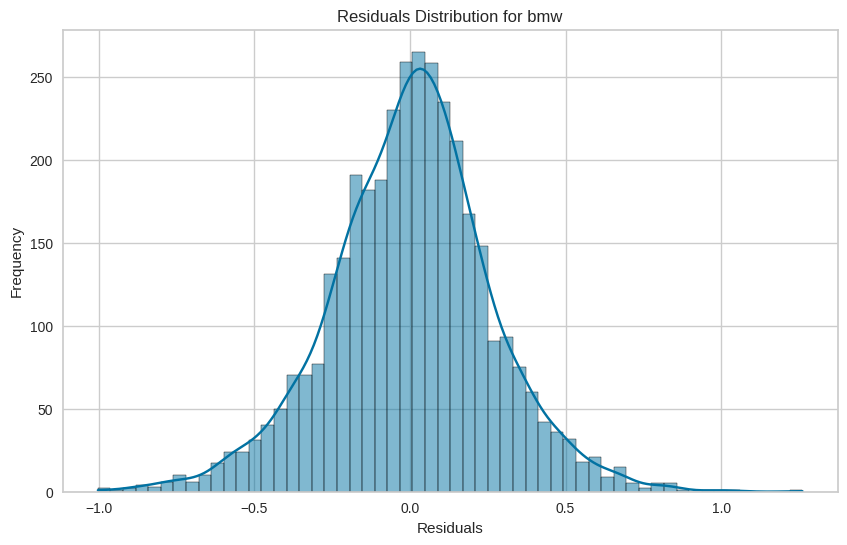

Evaluating for Brand: opel


,Description,Value
0,Session id,123
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(11133, 10)"
4,Transformed data shape,"(11133, 29)"
5,Transformed train set shape,"(7793, 29)"
6,Transformed test set shape,"(3340, 29)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1604,0.0456,0.2136,0.7847,0.0234,0.0197
1,0.1625,0.0441,0.2100,0.7912,0.0230,0.0200
2,0.1663,0.0486,0.2204,0.7690,0.0243,0.0206
3,0.1610,0.0450,0.2121,0.7981,0.0234,0.0199
4,0.1610,0.0455,0.2133,0.7943,0.0235,0.0200
Mean,0.1622,0.0457,0.2138,0.7875,0.0235,0.0200
Std,0.0022,0.0015,0.0035,0.0102,0.0004,0.0003


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1612,0.0460,0.2146,0.7827,0.0235,0.0198
1,0.1635,0.0446,0.2111,0.7889,0.0232,0.0202
2,0.1660,0.0481,0.2193,0.7713,0.0241,0.0205
3,0.1621,0.0457,0.2137,0.7950,0.0236,0.0201
4,0.1600,0.0449,0.2118,0.7971,0.0234,0.0198
Mean,0.1625,0.0458,0.2141,0.7870,0.0236,0.0201
Std,0.0021,0.0012,0.0029,0.0093,0.0003,0.0003


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.1590,0.0434,0.2083,0.7982,0.0229,0.0196


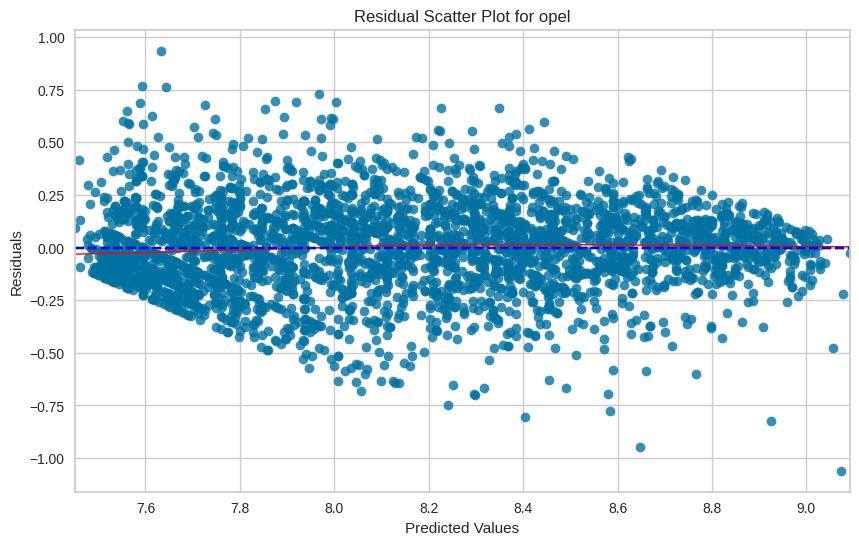

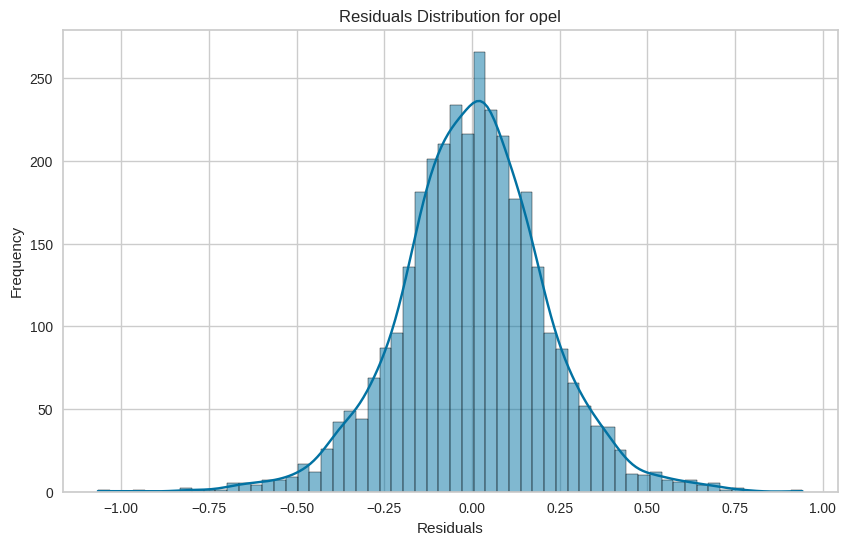

In [117]:
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns

df = filtered_df
# Get unique brands
unique_brands = df['brand'].unique()

for brand in unique_brands:
    print(f"Evaluating for Brand: {brand}")

    # Filter DataFrame for the current brand
    brand_df = df[df['brand'] == brand]

    if len(brand_df) > 30:  # Ensuring sufficient data
        # Setup PyCaret
        s = setup(data=brand_df, target='log_price', preprocess=True, session_id=123, fold=5)

        # Create and tune the CatBoost model
        catboost_model = create_model('catboost')
        tuned_model = tune_model(catboost_model)
        evaluate_model(tuned_model)

        # Predict on holdout set
        predictions = predict_model(tuned_model)

        # Extract actual and predicted values
        actual = predictions['log_price']
        predicted = predictionspredicted = predictions['prediction_label']

        # Calculate residuals
        residuals = actual - predicted

        # Plot residuals scatter plot
        plt.figure(figsize=(10, 6))
        sns.residplot(x=predicted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
        plt.title(f'Residual Scatter Plot for {brand}')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='blue', linestyle='--')
        plt.show()

        # Plot residuals histogram
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title(f'Residuals Distribution for {brand}')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    else:
        print(f"Not enough data for brand: {brand}")
